# Attention is all you need: Discovering the Transformer model

# Neural machine traslation using a Transformer model

In this notebook we will describe and demystify the relevant artifacts in the paper "Attention is all you need" (Vaswani, Ashish & Shazeer, Noam & Parmar, Niki & Uszkoreit, Jakob & Jones, Llion & Gomez, Aidan & Kaiser, Lukasz & Polosukhin, Illia. (2017)). This paper was a more advanced step in the use of the attention mechanism being the main basis for a model called Transformer. The most famous current models that are emerging in NLP tasks consist of dozens of transformers or some of their variants, for example, GPT-3 or BERT.

Attention is all you need: https://arxiv.org/pdf/1706.03762.pdf

We will describe the components of this model, analyze their operation and build a simple model that we will apply to a small-scale NMT problem (Neural Machine Translation). To read more about the problem that we will address and to know how the basic attention mechanism works, I recommend you to read my previous  post [ "A Guide on the Encoder-Decoder Model and the Attention Mechanism"](https://medium.com/better-programming/a-guide-on-the-encoder-decoder-model-and-the-attention-mechanism-401c836e2cdb) and check the [ repository](https://github.com/edumunozsala/NMT-encoder-decoder-Attention).

![Alt](images/transformer.jpg "title Picture by Vinson Tan from Pixabay")

## Why we need Transformer?

In sequence-to-sequence treatment problems such as the neural machine translation, the initial proposals were based on the use of RNNs in an encoder-decoder architecture. These architectures presented a great limitation when working with long sequences, their ability to retain information from the first elements was lost when new elements were incorporated into the sequence. In the encoder, the hidden state in every step is associated with a certain word in the input sentence, the more recent. Therefore, if the decoder only accesses the last hidden state of the decoder, it will lose relevant information about the first elements of the sequence. Then to deal with this limitation, a new concept were introduced **the attention mechanism**.

Instead of paying attention to the last state of the encoder as is usually done with the RNNs, in each step of the decoder we look at all the states of the encoder, being able to access information about all the elements of the input sequence. This is what attention does, it extracts information from the whole sequence, a weighted sum of all the past encoder states. This allows the decoder to assign greater weight or importance to a certain element of the input for each element of the output. Learning in every step to focus in the right element of the input to predict the next output element.

But this approach continues to have an important limitation, each sequence must be treated one at a time. Both the encoder and the decoder have to wait till the completion of t-1 steps to process at 't'th step. So when dealing with huge corpus **it is very time consuming and computationally inefficient**.

# Loading the libraries

Load and install, if necessary, the python libraries we will use along this notebook. We force to import Tensorflow version 2, if it is available.

In [126]:
import math
import os
import gc
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import drive

In [127]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
print(tfds.__version__)
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

2.11.0
4.8.3


Setting some parameters and hyperparameters for our model

In [128]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
NUM_SAMPLES = 258910 #40000 1364
MAX_VOCAB_SIZE = 2**14

BATCH_SIZE = 110  # Batch size for training.
EPOCHS = 1  # Number of epochs to train for.
MAX_LENGTH = 15

# Global parameters
root_folder='/content/drive'
data_folder_name='My Drive/Tesis/Traductor/datasets/eng_spa_translations'
checkpoint_folder = "My Drive/Tesis/Traductor/Transformer_NMT/Projects/Transformer_NMT/ckpt/"
train_filename='outputv13.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder))

# Both train and test set are in the root data directory
train_path = DATA_PATH


# The dataset and text processing

For this exercise we will use pairs of simple sentences, the source in English and target in Spanish, from the Tatoeba project where people contribute adding translations every day. This is the [link](http://www.manythings.org/anki/) to some traslations in different languages. There you can download the Spanish - English spa_eng.zip file, it contains 124457 pairs of sentences.

We use a list of **non breaking prefixes** to avoid the tokenizer to split or break words including that prefixes. Inm our example we do not want to remove some the dot for some well-konw words.You can find non breaking prefixes for many languages in the Kaggle website: 

https://www.kaggle.com/nltkdata/nonbreaking-prefixes/activity


The text sentences are almost clean, they are simple plain text, so we only need to remove dots that are not a end of sentence symbol and duplicated white spaces. 

The following functions will apply the cleaning mentioned previously:


In [129]:
def preprocess_text_nonbreaking(corpus, non_breaking_prefixes):
  try:
    # Initialize row_num variable
    row_num = 0
    # Initialize empty list to store preprocessed sentences
    preprocessed_sentences = []
    # Split corpus into sentences
    for sentence in corpus.split('.'):
      # Increment row_num variable
      row_num += 1
      # Eliminar caracteres de nueva línea
      sentence_cleaned = sentence.replace('\n', '')
      # Agregue espacio entre la palabra y el signo de puntuación
      sentence_cleaned = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', sentence_cleaned)
     # Eliminar espacios dobles
      sentence_cleaned = re.sub(r'\s\s', ' ', sentence_cleaned)
      # Para evitar eliminar puntos de algunas palabras
      for prefix in non_breaking_prefixes:
        sentence_cleaned = sentence_cleaned.replace(prefix, prefix + '$$$')
    # Elimina los puntos que no están al final de una oración
      sentence_cleaned = re.sub(r'\.(?=[0-9]|[a-z]|[A-Z])', '.$$$', sentence_cleaned)
      # Elimine los puntos restantes y reemplace $$$ con un punto
      sentence_cleaned = re.sub(r'\.|\$\$\$', ' . ', sentence_cleaned)
      # Eliminar múltiples espacios
      sentence_cleaned = re.sub(r'\s\s', ' ', sentence_cleaned)
      # Eliminar espacios al principio y al final de la cadena
      sentence_cleaned = sentence_cleaned.strip()
      # Agregar oración preprocesada a la lista
      preprocessed_sentences.append(sentence_cleaned)
    # Une oraciones preprocesadas en una sola cadena
    preprocessed_corpus = '. '.join(preprocessed_sentences)
    return preprocessed_corpus
  except Exception as e:
    print(f"Error processing row {row_num}: {e}")
    return None


## Loading the dataset

Mount our Google Drive unit to access the datafiles from the notebook

In [130]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the list of non breaking prefixes for the english and the spanish sentences

In [131]:
with open(DATA_PATH+"/nonbreaking_prefix.es", 
          mode = "r", encoding = "utf-8") as f:
    non_breaking_prefix_en = f.read()
with open(DATA_PATH+"/nonbreaking_prefix.en", 
          mode = "r", encoding = "utf-8") as f:
    non_breaking_prefix_es = f.read()

non_breaking_prefix_es= non_breaking_prefix_es.split("\n")
non_breaking_prefix_es = [' ' + pref + '.' for pref in non_breaking_prefix_es]
non_breaking_prefix_en = non_breaking_prefix_en.split("\n")
non_breaking_prefix_en = [' ' + pref + '.' for pref in non_breaking_prefix_en]

Load the dataset into a pandas dataframe and apply the preprocess function to the input and target columns.

In [9]:
 # Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header= None, names=[TARGET_COLUMN,INPUT_COLUMN], usecols=[0,1], 
                nrows=NUM_SAMPLES, encoding='utf-8')
df = df.dropna()
 # Preprocess the input data
# input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_en)).tolist()
#  # Preprocess and include the end of sentence token to the target text
# target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_es)).tolist()

# Preprocess and include the end of sentence token to the target text
target_data = []
for text in df[TARGET_COLUMN]:
    preprocessed_text = preprocess_text_nonbreaking(text, non_breaking_prefix_es)
    if preprocessed_text is not None:
        target_data.append(preprocessed_text)

input_data = []
for text in df[INPUT_COLUMN]:
    preprocessed_text = preprocess_text_nonbreaking(text, non_breaking_prefix_en)
    if preprocessed_text is not None:
        input_data.append(preprocessed_text)

print('Number of sentences: ',len(input_data))
print(input_data[:15])
print(target_data[:15])

Number of sentences:  258693
['Ve. ', 'Vete. ', 'Vaya. ', 'Váyase. ', 'Hola. ', '¡Corre!', '¡Corran!', '¡Huye!', '¡Corra!', '¡Corred!', 'Corra. ', 'Corred. ', '¿Quién ?', '¡Órale!', '¡Inclínate!']
['Go. ', 'Go. ', 'Go. ', 'Go. ', 'Hi. ', 'Run!', 'Run!', 'Run!', 'Run!', 'Run!', 'Run. ', 'Run. ', 'Who ?', 'Wow!', 'Duck!']


In [10]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

41

# Tokenize the text data

Next, let's see how to prepare the data for our model. It is very simple and the steps are the following:

- Create the vocabulary from the corpus using Subword tokenization, breaking words into “subword units” - strings of characters like ing or eau - that allow the downstream model to make intelligent decisions on words it doesn’t recognize.
- Calculate the maximum length of the input and output sequences.
- Tokenize the data, convert the raw text into a sequence of integers. Once we define the vocabulary, we use the encode method to get the token for every word in the corpus.
- Remove sentences longer that the max length defined.
- Padding the sentences: we need to pad zeros at the end of the sequences so that all sequences have the same length. Otherwise, we won't be able train the model on batches

In [11]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove

In [12]:
# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs= subword_tokenize(input_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(target_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)

In [13]:
# Check the tokenize function
print(encoder_inputs[:5], sos_token_input, eos_token_input)
print(decoder_outputs[:5], sos_token_output, eos_token_output)

[[16481  4322     2 16482     0     0     0     0     0     0     0     0
      0     0     0]
 [16481  4322   260     2 16482     0     0     0     0     0     0     0
      0     0     0]
 [16481 13398     2 16482     0     0     0     0     0     0     0     0
      0     0     0]
 [16481 16033  1364   443     2 16482     0     0     0     0     0     0
      0     0     0]
 [16481  3282     2 16482     0     0     0     0     0     0     0     0
      0     0     0]] [16481] [16482]
[[16612  2537     1 16613     0     0     0     0     0     0     0     0
      0     0     0]
 [16612  2537     1 16613     0     0     0     0     0     0     0     0
      0     0     0]
 [16612  2537     1 16613     0     0     0     0     0     0     0     0
      0     0     0]
 [16612  2537     1 16613     0     0     0     0     0     0     0     0
      0     0     0]
 [16612  1726     1 16613     0     0     0     0     0     0     0     0
      0     0     0]] [16612] [16613]


In [14]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_output)

Size of Input Vocabulary:  16483
Size of Output Vocabulary:  16614


# Create the batch data generator

- Create a batch data generator: we want to train the model on batches, group of sentences, so we need to create a Dataset using the tf.data library and the function batch_on_slices on the input and output sequences.

In [15]:
# # Define a dataset 
# dataset = tf.data.Dataset.from_tensor_slices(
#     (encoder_inputs, decoder_outputs))
# dataset = dataset.shuffle(len(input_data), reshuffle_each_iteration=True).batch(
#     BATCH_SIZE, drop_remainder=True)

# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Pad encoder_inputs y decoder_outputs con ceros hasta la longitud máxima
encoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(encoder_inputs, maxlen=MAX_LENGTH, padding='post', truncating='post')
decoder_outputs = tf.keras.preprocessing.sequence.pad_sequences(decoder_outputs, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Define un conjunto de datos a partir de los arrays numpy
dataset = tf.data.Dataset.from_tensor_slices((encoder_inputs, decoder_outputs))

# Mezcla los datos y agrupa en lotes del tamaño BATCH_SIZE
dataset = dataset.shuffle(len(input_data), reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=True)

# Prefetch para acelerar el procesamiento
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Building a Transformer

## What is Transformer?
*"In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output. The Transformer allows for significantly more parallelization … the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution."*

"Attention is all you need" paper

The Transformer model extract  features for each word using a self-attention mechanism to figure out how important all the other words in the sentence are w.r.t. to the aforementioned word. And no recurrent units are used to obtain this features, they are just weighted sum and activations, so they can be very parallelizable and efficient.

But We will dive deeper to understand what all this means.

# Self-attention: the fundamental operation

*"Self-attention is a sequence-to-sequence operation: a sequence of vectors goes in, and a sequence of vectors comes out. Let's call the input vectors 𝐱1,𝐱2,…𝐱t and the corresponding output vectors 𝐲1,𝐲2,…,𝐲t. The vectors all have dimension k. To produce output vector 𝐲i, the self attention operation simply takes a weighted average over all the input vectors, the simplest option is the dot product."*

**Transformers from scratch by Peter Bloem**

In the self-attention mechanism of our model we need to introduce three elements: Queries, Values and Keys



## Queries, Keys and Values
Every input vector is used in three different ways in the self-attention mechanism: the Query, the Key and the Value. In every role, it is compared to the others vectors to get its own output yi (Query), to get the j-th output yj (Key) and to compute each output vector once the weights have been established (Value).

To obtain this roles, we need three weight matrices of dimensions k x k and compute three linear transformation for each xi:

![Alt](images/query_key_value.png "title "Transformers from scratch" by Peter Bloem")

These three matrices are usually known as K, Q and V, three learnable weight layers that are applied to the same encoded input. Consequently, as each of these three matrices come from the same input, we can apply the attention mechanism of the input vector with itself, a "self-attention".


## Scale dot-product Attention

*The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the query with all keys, divide each by the square root of dk, and apply a softmax function to obtain the weights on the values.*

"Attention is all you need" paper

Then we use the Q, K and V matrices to calculate the attention scores. **The scores measure how much focus to place on other places or words of the input sequence w.r.t a word at a certain position**. That is, the dot product of the query vector with the key vector of the respective word we're scoring. So, for position 1 we calculate the dot product (.) of q1 and k1, then q1 . k2, q1 . k3,… 

Next we apply the "scaled" factor to have more stable gradients. The softmax function can not work properly with large values, resulting in vanishing the gradient and slow down the learning. After "softmaxing" we multiply by the Value matrix to keep the values of the words we want to focus on and minimizing or removing the values for the irrelevant words (its value in V matrix should be very small).

The formula for these operations is:

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $


In [16]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

## Multi-Head Attention

In the previous description the attention scores are focused on the whole sentence at a time, this would produce the same results even if two sentences contain the same words in a different order. Instead, we would like to attend to different segments of the words. We can give the self attention greater power of discrimination, **by combining several self attention heads**, dividing the words vectors into a fixed number (h, number of heads) of chunks, and then self-attention is applied on the corresponding chunks, using Q, K and V sub-matrices. 

This produce h different output matrices of scores.

![Alt](images/dor_product_multihead.PNG "title From "Attention is all you need" paper by Vaswani, et al., 2017")

But the next layer (the Feed-Forward layer) is expecting just one matrix, a vector for each word, so after calculating the dot product of every head, we concat the output matrices and multiply them by an additional weights matrix $W_O$. This final matrix captures information from all the attention heads.

$MultihHead(Q, K, V ) = \text{Concat}(head_1,...,head_n)W^O$

where $head_i=Attention(QW_i^Q,QW_i^K,QW_i^V)$ and $i$ is the head index.


In [17]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

# Positional Encoding

We mentioned briefly that the order of the words in the sentence is an issue to solve in this model, because the network and the self-attention mechanism is permutation invariant. If we shuffle up the words in the input sentence, we get the same solutions. We need to create a representation of the position of the word in the sentence and add it to the word embedding.

*To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension as the embeddings, so that the two can be summed. There are many choices of positional encodings.*

"Attention is all you need" paper

So, we apply a function to map the position in the sentence to real valued vector. The network will learn how to use this information. Another approach would be to use a position embedding, similar to word embedding, coding every known position with a vector. It would requiere sentences of all accepted positions during training but positional encoding allow the model to extrapolate to sequence lengths longer than the ones encountered.

In the paper a sinusoidal function is applied:

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

In [18]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

# The Encoder

Now that all the main pieces of the model have been described we can introduce the encoder components. 

- Positional encoding: Add the position encoding to the input embedding (our input words are transformed to embedding vectors). *"The same weight matrix is shared between the two embedding layers (encoder and decoder) and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by square root of the model dimension"* [1], ${\sqrt{d_{model}}}$.

- N = 6, identical layers, containing two sub-layers: a **multi-head self-attention mechanism**, and a **fully connected feed-forward network**. This FC layer is applied to each position separately and identically and consists of two linear transformations with a ReLU activation in between. But it is applied position-wise to the input, which means that the same neural network is applied to every single "token" vector belonging to the sentence sequence.

$$FFN(x)= max(0,xW_1+b_1)W_2+b_2$$

- There is a residual connection around each sub-layer (attention and FC network) followed by a layer normalization.

*Normalization and residual connections are standard tricks used to help deep neural networks train faster and more accurately. The layer normalization is applied over the embedding dimension only.*

**Peter Bloem, "Transformers from scratch"**

The next figure will show the components detailed:

![Alt](images/encoder.PNG "title "The Ilustrated Transformer" by Jay Alammar")

Keep in mind that **only the vector from the last layer (6-th) is sent to the decoder**.

In [19]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [20]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

# The Decoder

The decoder share some components with the encoder but they are used in a different way to take into account the encoder output.

- Positional encoding: Similar that the one in the encoder
- N=6 identical layers, containing 3 three sublayers. First, the Masked Multi-head attention or **masked causal attention** to prevent positions from attending to subsequent positions, hiding those features that belong to future states of the sequence. "This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i" [1]. It is implemented setting to −∞ the values corresponding to the forbidden states in the softmax layer of the dot-product attention modules. The second component or **"encoder-decoder attention"** performs multi-head attention over the output of the decoder, the Key and Value vectors come from the output of the encoder but the queries come from the previous decoder layer. *This allows every position in the decoder to attend over all positions in the input sequence* [1]. And finally the fully-connected network.

- The residual connection and layer normalization around each sub-layer, similar to the encoder.

![Alt](images/decoder.PNG "title "The Ilustrated Transformer" by Jay Alammar")

At the end of the N stacked decoders, the **linear layer**, a fully-connected network, transforms the stacked outputs to a much larger vector, the *logits*. The **softmax layer** then turns those scores (logits) into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.


In [21]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [22]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)

        return outputs

# Transformer

Once we have defined our components and created the encoder, the decoder and the linear-softmax final layer, we join the pieces to form our model, the Transformer.

![Alt](images/transformer_architecture.PNG "title "Attention is all you need" paper")

In [23]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs

It is worth mentioning that we create 3 masks, each of which will allow us:
- *Encoder mask*: It is a padding mask to discard the pad tokens from the attention calculation.
- *Decoder mask 1*: this mask is a union of the padding mask and the look ahead mask which will help the causal attention to discard the tokens "in the future". We take the maximum value between the padding mask and the look ahead one.
- *Decoder mask 2*: it is the padding mask and is applied in the encoder-decoder attention layer.

As you can see then we call the encoder, the decoder and the final linear-softmax layer to get the predicted output from our Transformer model.

# Training the Transformer model
Now that we have described in detail the components in the paper we are ready to implement them and train a transformer model on a NMT problem. It is a toy problem for educational purposes.

We need to create a custom loss function to mask the padding tokens and we define the Adam optimizer described in the paper, with beta1 = 0.9, beta2 = 0.98 and epsilon= 10e-9. And then we create a scheduler to vary the learning rate over the training process according to:

$lrate = d_{model}^{-0.5}*min(step\_num^{-0.5}, step\_num*warmup\_steps^{-1.5})$


In [24]:
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


And that's all, we have all the necessary elements to train our model using an usual loop for sequence-to-sequence tasks:
- For every iteration on the batch generator that produce batch size inputs and outputs
- Get the input sequence from 0 to length-1 and the actual outputs from 1 to length, the next word expected at every sequence step.
- Call the transformer to get the predictions
- Calculate the loss function between the real outputs and the predictions
- Apply the gradients to update the weights in the model
- Calculate the mean loss and the accuracy for the batch data
- Show some results and save the model in every epoch

In [25]:
def main_train(dataset, transformer, n_epochs, print_every=50):
  ''' Entrene el modelo de transformador para n_epochs usando el conjunto de datos del generador de datos'''
  losses = []
  accuracies = []
  # En cada epoca
  for epoch in range(n_epochs):
    print("Época de inicio {}".format(epoch+1))
    start = time.time()
    # Restablecer los cálculos de pérdida y precisión
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Obtenga un lote de entradas y objetivos
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Establecer las salidas de destino, desplazadas a la derecha
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
           # Llame al transformador y obtenga la salida prevista
            predictions = transformer(enc_inputs, dec_inputs, True)
           # Calcular la pérdida
            loss = loss_function(dec_outputs_real, predictions)
       # Actualiza los pesos y el optimizador
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # Guardar y almacenar las métricas
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Época {} Lote {} Pérdida {:.4f} Exactitud {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
  # Verifique el modelo en cada época    
    ckpt_save_path = ckpt_manager.save()
    print("Guardando el punto de control para la época {} en {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Tiempo para 1 época: {} segundos\n".format(time.time() - start))

  return losses, accuracies

Setting the hyperparameters and parameters of the model and training process:

In [26]:
# Set hyperparamters for the model
D_MODEL = 512 # 512
N_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.1 # 0.1


Now we define and create all the elements to train the model and evaluate it.

In [27]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
learning_rate = CustomSchedule(D_MODEL)
step = 1000.0
lr = learning_rate(step)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
        

It is very useful to checkpoint and save our model during training. Training can take a lot of time and we can restore the model for future training or use.

In [28]:
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Último punto de control restaurado.")
    #return transformer.train_loss.result().numpy(), transformer.train_accuracy.result().numpy(), transformer.val_loss.result().numpy(), transformer.val_accuracy.result().numpy()


Último punto de control restaurado.


In [29]:
# Train the model
losses, accuracies = main_train(dataset, transformer, EPOCHS, 100)

Época de inicio 1


Época 1 Lote 0 Pérdida 0.2229 Exactitud 0.7058
Época 1 Lote 100 Pérdida 0.2461 Exactitud 0.6841
Época 1 Lote 200 Pérdida 0.2479 Exactitud 0.6829
Época 1 Lote 300 Pérdida 0.2531 Exactitud 0.6826
Época 1 Lote 400 Pérdida 0.2553 Exactitud 0.6810
Época 1 Lote 500 Pérdida 0.2594 Exactitud 0.6803
Época 1 Lote 600 Pérdida 0.2631 Exactitud 0.6799
Época 1 Lote 700 Pérdida 0.2661 Exactitud 0.6794
Época 1 Lote 800 Pérdida 0.2693 Exactitud 0.6784
Época 1 Lote 900 Pérdida 0.2713 Exactitud 0.6779
Época 1 Lote 1000 Pérdida 0.2737 Exactitud 0.6777
Época 1 Lote 1100 Pérdida 0.2757 Exactitud 0.6770
Época 1 Lote 1200 Pérdida 0.2783 Exactitud 0.6762
Época 1 Lote 1300 Pérdida 0.2811 Exactitud 0.6758
Época 1 Lote 1400 Pérdida 0.2834 Exactitud 0.6749
Época 1 Lote 1500 Pérdida 0.2850 Exactitud 0.6746
Época 1 Lote 1600 Pérdida 0.2872 Exactitud 0.6742
Época 1 Lote 1700 Pérdida 0.2894 Exactitud 0.6737
Época 1 Lote 1800 Pérdida 0.2911 Exactitud 0.6734
Época 1 Lote 1900 Pérdida 0.2928 Exactitud 0.6729
Época 1 Lote

## Show some results from training

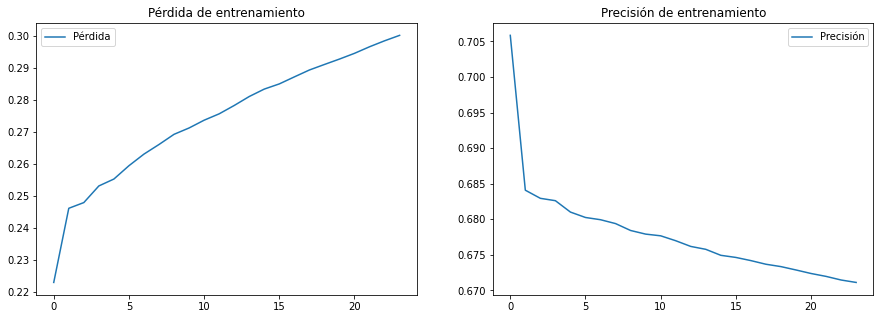

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='Pérdida')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Pérdida de entrenamiento')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='Precisión')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Precisión de entrenamiento')
ax2.legend()
plt.show()

# Make predictions

We have seen the scores obtained after training but what we are interested in making predictions and see how the model works with new sentences. The predict function will input a tokenize sentence to the model and return the predicted new sentence, in our example, a translation from english to spanish. 
- Tokenize the input sentence to a sequence of tokens
- Set the initial output sequence to the SOS token
- Until we reach the max length or the eos token is returned by the model
- Get the next word predicted. The model returns the logits, remember that the softmax function is applied in the loss calculation.
- Get the index in the vocabulary of the word with the highest probability
- Concat the next word predicted to the output sequence

In [31]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions = transformer(enc_input, output, False) #(1, seq_length, VOCAB_SIZE_ES)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

And finally our last function receives a sentence in english, calls the transformer to translate it to spanish and shows the result

In [32]:
def translate(sentence):
    # Get the predicted sequence for the input sentence
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    # Transform the sequence of tokens to a sentence
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence

First, we explore the predictions on sentences of our training dataset:

In [33]:
#Show some translations
sentence = "Deberías esperar por lo que te quieras."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Deberías esperar por lo que te quieras.
Output sentence: You should wait for whatever you want to hear


In [ ]:
#Show some translations
sentence = "No tenemos el pelo de dinero."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: No tenemos el pelo de dinero.
Output sentence: We have no money-up hair. 


Next, let's predict some new sentences on diferent topics:

In [ ]:
#Show some translations
sentence = "Debería haber conocido mejor"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Debería haber conocido mejor
Output sentence: I should've met better. 


In [ ]:
#Show some translations
sentence = "¿Un equivalente Java de fflush de C?"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: ¿Un equivalente Java de fflush de C?
Output sentence: A Java equivalent of C's fflush ?


Comparador


In [ ]:
#Show some translations
sentence = "Este es un curso interesante sobre Procesamiento del Lenguaje Natural"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Este es un curso interesante sobre Procesamiento del Lenguaje Natural
Output sentence: This is an interesting course about Naural language processing


In [34]:
!pip install flair --use-deprecated=legacy-resolver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 KB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 99.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 63.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 KB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 18.4 MB/s eta 0:00:00
  Installin

In [59]:
pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importacion de librerias Modelo Bert y Glove

In [37]:
import numpy as np
import pandas as pd
from flair.embeddings import WordEmbeddings, TransformerWordEmbeddings
from flair.data import Sentence
from scipy.spatial import distance
from scipy.spatial.distance import cosine, euclidean

# Load Glove Embeddings

glove_embedding = WordEmbeddings('glove')

# Load BERT Embeddings
bert_embedding = TransformerWordEmbeddings('bert-base-multilingual-cased')

2023-03-21 14:08:43,781 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmp5zv53x1r


100%|██████████| 153M/153M [00:04<00:00, 37.4MB/s]

2023-03-21 14:08:48,146 copying /tmp/tmp5zv53x1r to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2023-03-21 14:08:48,383 removing temp file /tmp/tmp5zv53x1r
2023-03-21 14:08:48,510 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpll1rjstk


100%|██████████| 20.5M/20.5M [00:00<00:00, 34.6MB/s]

2023-03-21 14:08:49,245 copying /tmp/tmpll1rjstk to cache at /root/.flair/embeddings/glove.gensim
2023-03-21 14:08:49,275 removing temp file /tmp/tmpll1rjstk


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Definicion de ruta para dataset

In [38]:
# Global parameters
root_folder_compare='/content/drive/My Drive/Tesis/Traductor/datasets/eng_spa_translations/'
DataSet_compare = "df_so.txt"
data=-0.21 
# Variable for data directory
DATA_PATH_COMPARE = os.path.abspath(os.path.join(root_folder_compare, DataSet_compare))
print("URl Data Set {}".format(DATA_PATH_COMPARE))

URl Data Set /content/drive/My Drive/Tesis/Traductor/datasets/eng_spa_translations/df_so.txt


Carga de data set

In [39]:
# Load questions from CSV file
questions_df = pd.read_csv(DATA_PATH_COMPARE, sep="\t", header=None, encoding='ISO-8859-1')
print("data: {}".format(questions_df))

data:                                                       0
0                                 Class views in Django
1                           How to use XPath in Python?
2           SQL Server: Get data for only the past year
3                        How to sort a list of strings?
4         Using Django time/date widgets in custom form
...                                                 ...
4875  Create a django password in a simple python sc...
4876  How can I pass unique id fields from a Model t...
4877  How Django and JavaScript work together for ru...
4878  Performing a SQL query to get cocktails by ing...
4879  How to display the user Avatar on all template...

[4880 rows x 1 columns]


Utilizacion del Modelo Transformer

In [40]:
user_input_str = "Captura de parámetros de URL en request.GET"
print("Input sentence: {}".format(user_input_str))

# Traducir la entrada del usuario
predicted_sentence = translate(user_input_str)
print("Output sentence: {}".format(predicted_sentence))

# Convierta la oración predicha en objeto de oración para incrustaciones
user_input = Sentence(predicted_sentence)
print("Output sentence para comparador: {}".format(user_input))
glove_similarities = []
bert_similarities = []

Input sentence: Captura de parámetros de URL en request.GET
Output sentence: Capturing URL parameters on requestwould GETGET
Output sentence para comparador: Sentence[6]: "Capturing URL parameters on requestwould GETGET"


Implementacion de decriminacion del umbral 

In [41]:
max_len = max(len(Sentence(row[0])) for i, row in questions_df.iterrows())
umbral = 0.80  # Umbral para considerar que una pregunta es similar a la entrada del usuario
data=-0.21 
# variables tipo contador
filaProcesBert= 0
filaGlove=0 
filaProcesBertCero= 0
filaGloveCero=0 
fila = 1

results_df = pd.DataFrame(columns=['user','csv_question', 'Similar','probability'])
results_df.drop(results_df.index, inplace=True)
Data_Glove = pd.DataFrame(columns=['user','csv_question', 'Similar','probability'])
Data_Glove.drop(Data_Glove.index, inplace=True)

# Repasar cada pregunta en el archivo CSV y compararla con la entrada del usuario
for i, row in questions_df.iterrows():
    fila += 1
    question = row[0]

    # Crear objetos Sentence para la entrada del usuario y cada pregunta en el archivo CSV
    csv_question = Sentence(question)

    # Obtener las listas de embeddings para la entrada del usuario y la pregunta en el archivo CSV
    glove_embedding.embed(user_input)
    glove_embedding.embed(csv_question)
    # Obtener las listas de embeddings GloVe como arrays de numpy
    user_input_array = np.array([token.embedding.cpu().numpy() for token in user_input])
    csv_question_array = np.array([token.embedding.cpu().numpy() for token in csv_question])

    # Padding para igualar la longitud de las secuencias
    user_input_padded = np.zeros((max_len, user_input_array.shape[1]))
    user_input_padded[:user_input_array.shape[0], :] = user_input_array
    csv_question_padded = np.zeros((max_len, csv_question_array.shape[1]))
    csv_question_padded[:csv_question_array.shape[0], :] = csv_question_array

    # Calcular la distancia del coseno entre las dos secuencias usando embeddings GloVe
    glove_dst = data +cosine(user_input_padded.flatten()[:csv_question_padded.size], csv_question_padded.flatten())
     
    #glove_sim_percent = glove_dst * 100  # Convertir la similitud en porcentaje

    #glove_euclidean = euclidean(user_input_padded.flatten()[:csv_question_padded.size], csv_question_padded.flatten())

    # Obtener las listas de embeddings BERT para la entrada del usuario y la pregunta en el archivo CSV
    bert_embedding.embed(user_input)
    bert_embedding.embed(csv_question)

    # Obtener las listas de embeddings BERT como arrays de numpy
    user_input_array = np.array([token.embedding.cpu().numpy() for token in user_input])
    csv_question_array = np.array([token.embedding.cpu().numpy() for token in csv_question])

    # Padding para igualar la longitud de las secuencias
    user_input_padded = np.zeros((max_len, user_input_array.shape[1]))
    user_input_padded[:user_input_array.shape[0], :] = user_input_array
    csv_question_padded = np.zeros((max_len, csv_question_array.shape[1]))
    csv_question_padded[:csv_question_array.shape[0], :] = csv_question_array

    # Calcular la distancia coseno entre las dos secuencias usando embeddings BERT
    #bert_dst = distance.euclidean(user_input_padded.flatten(), csv_question_padded.flatten())
    cos_sim =distance.cosine(user_input_padded.flatten(), csv_question_padded.flatten())
    #cos_sim_percent = cos_sim * 100

    # Etiquetar la pregunta con 1 si la similitud coseno es mayor que el umbral, o con 0 si es menor o igual
    if cos_sim > umbral:
        is_similar = 1
        #print("Fila: {}".format(i))
        #print(f"Bert euclidean distance: {cos_sim:.4f}")
        filaProcesBert += 1
        #print(is_similar)
    else:
        is_similar = 0
        filaProcesBertCero += 1
    #print(f"Glove euclidean distance: {glove_dst:.4f}")
    if glove_dst > umbral:
        is_similar_Glove = 1
        # print("Fila: {}".format(i))
        # print(f"Glove euclidean distance: {glove_dst:.4f}")
        filaGlove += 1
        #print(is_similar)
    else:
        is_similar_Glove = 0
        filaGloveCero += 1

    #results_df = results_df.append({'user':1 ,'csv_question': i+1, 'Similar':int(is_similar)}, ignore_index=True)   
    results_df = pd.concat([results_df, pd.DataFrame({'user':1 ,'csv_question': i+1, 'Similar':int(is_similar)}, index=[0])], ignore_index=True)

    #Data_Glove = Data_Glove.append({'user':1 ,'csv_question': i+1, 'Similar': int(is_similar_Glove)}, ignore_index=True) 
    Data_Glove = pd.concat([Data_Glove, pd.DataFrame({'user':1 ,'csv_question': i+1, 'Similar':int(is_similar)}, index=[0])], ignore_index=True)

# Imprimir el nuevo dataframe con los resultados
print("="*30)
print("Resultdos de Bert")
print(results_df)
print("Cantidad de preguntas positivas con Bert: {}".format(filaProcesBert))
print("Cantidad de preguntas negativas con Bert: {}".format(filaProcesBertCero))

print("="*30)
print("Resultdos de Glove")
print(Data_Glove)
print("Cantidad de preguntas  positivas con Glove: {}".format(filaGlove))
print("Cantidad de preguntas  negativas con Glove: {}".format(filaGloveCero))


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Resultdos de Bert
     user csv_question Similar probability
0       1            1       0         NaN
1       1            2       0         NaN
2       1            3       0         NaN
3       1            4       0         NaN
4       1            5       0         NaN
...   ...          ...     ...         ...
4875    1         4876       0         NaN
4876    1         4877       1         NaN
4877    1         4878       0         NaN
4878    1         4879       0         NaN
4879    1         4880       0         NaN

[4880 rows x 4 columns]
Cantidad de preguntas positivas con Bert: 659
Cantidad de preguntas negativas con Bert: 4221
Resultdos de Glove
     user csv_question Similar probability
0       1            1       0         NaN
1       1            2       0         NaN
2       1            3       0         NaN
3       1            4       0         NaN
4       1            5       0         NaN
...   ...          ...     ...         ...
4875    1         4876      

Aplicacion de la curva de Roc Grafica modelo Glove

AUC=0.55164


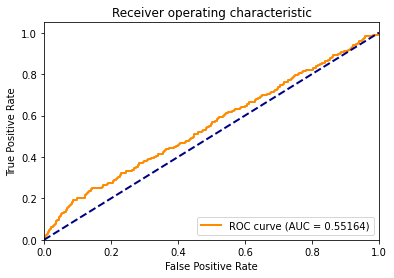

Threshold=0.161 


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from numpy import arange, argmax

# Extraer características y etiquetas
X = Data_Glove['csv_question'].to_numpy()
y = Data_Glove['Similar'].to_numpy()

y = y.astype('int')  # convertir a tipo de datos entero
y = pd.Series(y).fillna(0).values  # reemplazar valores nulos con ceros

# Dividir en conjuntos de entrenamiento y prueba
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# Entrenar modelo de regresión logística
model = LogisticRegression(solver='lbfgs')
model.fit(trainX.reshape(-1, 1), trainy)

# Predecir probabilidades en el conjunto de prueba
yhat = model.predict_proba(testX.reshape(-1, 1))
# Mantener las probabilidades positivas
probs = yhat[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(testy, probs)
roc_auc = auc(fpr, tpr)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)

# Graficar curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Encontrar el mejor umbral
ix = argmax(tpr - fpr)
threshold = thresholds[ix]

# Imprimir el mejor umbral
print('Threshold=%.3f ' % (thresholds[ix]))

# print('Mejor umbral=%f' % (threshold))

Aplicacion de la curva de Roc Grafica modelo Bert

AUC=0.55164


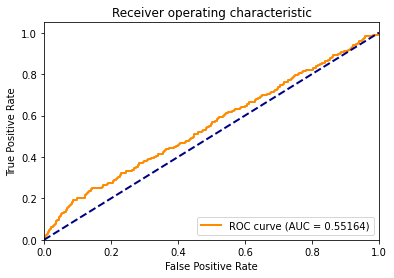

NameError: ignored

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Extraer características y etiquetas
X = results_df['csv_question'].to_numpy()
y = results_df['Similar'].to_numpy()

y = y.astype('int')  # convertir a tipo de datos entero
y = pd.Series(y).fillna(0).values  # reemplazar valores nulos con ceros

# Dividir en conjuntos de entrenamiento y prueba
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# Entrenar modelo de regresión logística
model = LogisticRegression(solver='lbfgs')
model.fit(trainX.reshape(-1, 1), trainy)

# Predecir probabilidades en el conjunto de prueba
yhat = model.predict_proba(testX.reshape(-1, 1))
# Mantener las probabilidades positivas
probs = yhat[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(testy, probs)
roc_auc = auc(fpr, tpr)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)

# Graficar curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Encontrar el mejor umbral
ix = argmax(tpr - fpr)
threshold = thresholds[ix]

# Imprimir el mejor umbral
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

# print('Mejor umbral=%f' % (threshold))

Resultados de preguntas marcada como 1 o 0 

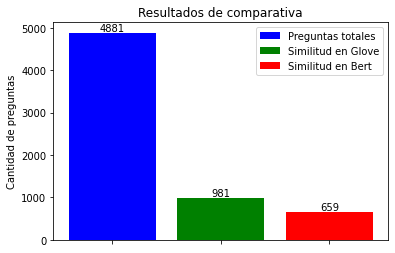

In [44]:
preguntas_totales = fila
preguntas_duplicadas = filaGlove
preguntas_bert= filaProcesBert


# Crear la figura y los ejes
fig, ax = plt.subplots()

# Crear las barras
rects1 = ax.bar(0, preguntas_totales, color='b', label='Preguntas totales')
rects2 = ax.bar(1, preguntas_duplicadas, color='g', label='Similitud en Glove')
rects3 = ax.bar(2, preguntas_bert, color='r', label='Similitud en Bert')

# Agregar etiquetas a las barras
ax.annotate(preguntas_totales, xy=(0, preguntas_totales), ha='center', va='bottom')
ax.annotate(preguntas_duplicadas, xy=(1, preguntas_duplicadas), ha='center', va='bottom')
ax.annotate(preguntas_bert, xy=(2, preguntas_bert), ha='center', va='bottom')


# Agregar etiquetas a los ejes
ax.set_ylabel('Cantidad de preguntas')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['', '', ''])

# Agregar título y leyenda
ax.set_title('Resultados de comparativa')
ax.legend()

# Mostrar el gráfico
plt.show()

Definicion de  funcion para determinar threshold y la probabilidades

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

def apply_threshold(probs, threshold):
    return (probs >= threshold).astype(int)

def get_threshold_auc(df):
    # Extraer características y etiquetas
    X = df['csv_question'].to_numpy()
    y = df['Similar'].to_numpy()
    y = y.astype('int')
    y = pd.Series(y).fillna(0).values
    
    # Dividir en conjuntos de entrenamiento y prueba
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

    # Entrenar modelo de regresión logística
    model = LogisticRegression(solver='lbfgs')
    model.fit(trainX.reshape(-1, 1), trainy)

    # Predecir probabilidades en todo el conjunto de datos
    yhat = model.predict_proba(X.reshape(-1, 1))
    probs = yhat[:, 1]

    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)

    # Encontrar el mejor umbral
    ix = np.argmax(tpr - fpr)
    threshold = thresholds[ix]

    # Aplicar el umbral a las probabilidades predichas
    preds = apply_threshold(probs, threshold)

    return threshold, preds


Matrix de confusion Modelo Glove 

[1 1 1 ... 0 0 0]
AUC=0.55164
Threshold=0.147
Precision=0.169
Accuracy=0.673
Recall=0.364
F1 score=0.231


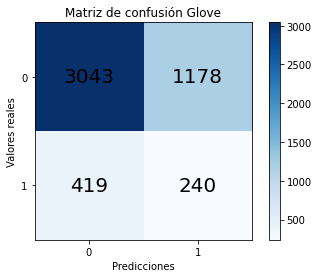

     user csv_question  Similar  probability
0       1            1        0            1
1       1            2        0            1
2       1            3        0            1
3       1            4        0            1
4       1            5        0            1
...   ...          ...      ...          ...
4875    1         4876        0            0
4876    1         4877        1            0
4877    1         4878        0            0
4878    1         4879        0            0
4879    1         4880        0            0

[4880 rows x 4 columns]


In [46]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Obtener el umbral y las etiquetas predichas
threshold, preds = get_threshold_auc(Data_Glove)
print(preds)
Data_Glove['Similar'].fillna(value=0, inplace=True)
# Calcular matriz de confusión
cm = confusion_matrix(Data_Glove['Similar'], preds)
# print(cm)

precision = precision_score(Data_Glove['Similar'], preds)
accuracy = accuracy_score(Data_Glove['Similar'], preds)
recall = recall_score(Data_Glove['Similar'], preds)
f1 = f1_score(Data_Glove['Similar'], preds)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)
print('Threshold=%.3f' % threshold)
print('Precision=%.3f' % precision)
print('Accuracy=%.3f' % accuracy)
print('Recall=%.3f' % recall)
print('F1 score=%.3f' % f1)

# Graficar matriz de confusión
plt.imshow(cm, cmap='Blues')
plt.title('Matriz de confusión Glove')
plt.colorbar()
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black', fontsize=20)
plt.show()
Data_Glove['probability'] = preds
print(Data_Glove)

Matrix de confusion Modelo Bert 

[1 1 1 ... 0 0 0]
AUC=0.55164
Threshold=0.147
Precision=0.169
Accuracy=0.673
Recall=0.364
F1 score=0.231


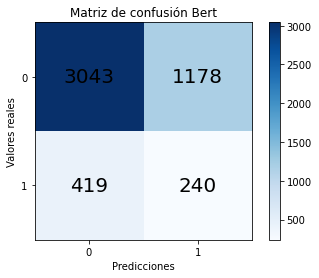

     user csv_question  Similar  probability
0       1            1        0            1
1       1            2        0            1
2       1            3        0            1
3       1            4        0            1
4       1            5        0            1
...   ...          ...      ...          ...
4875    1         4876        0            0
4876    1         4877        1            0
4877    1         4878        0            0
4878    1         4879        0            0
4879    1         4880        0            0

[4880 rows x 4 columns]


In [47]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Obtener el umbral y las etiquetas predichas
threshold, preds = get_threshold_auc(results_df)
print(preds)
results_df['Similar'].fillna(value=0, inplace=True)



# Calcular matriz de confusión
cm = confusion_matrix(results_df['Similar'], preds)
# print(cm)

precision = precision_score(results_df['Similar'], preds)
accuracy = accuracy_score(results_df['Similar'], preds)
recall = recall_score(results_df['Similar'], preds)
f1 = f1_score(results_df['Similar'], preds)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)
print('Threshold=%.3f' % threshold)
print('Precision=%.3f' % precision)
print('Accuracy=%.3f' % accuracy)
print('Recall=%.3f' % recall)
print('F1 score=%.3f' % f1)

# Graficar matriz de confusión
plt.imshow(cm, cmap='Blues')
plt.title('Matriz de confusión Bert')
plt.colorbar()
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black', fontsize=20)
plt.show()

results_df['probability'] = preds
print(results_df)


Nueva implementacion

In [ ]:
root_folder_compare = '/content/drive/My Drive/Tesis/Traductor/datasets/eng_spa_translations/'
DataSet_compare = "DataSetCompare.txt"

# Variable for data directory
DATA_PATH_COMPARE = os.path.abspath(os.path.join(root_folder_compare, DataSet_compare))
print("URl Data Set {}".format(DATA_PATH_COMPARE))

# Load questions from CSV file into a dataframe
questions_df_new = pd.read_csv(DATA_PATH_COMPARE, sep='\t', header=0, encoding='UTF-8')
#questions_df_new = pd.read_csv(DATA_PATH_COMPARE, sep='\t', header=0, encoding='ISO-8859-1')

# Assign column names to the dataframe
questions_df_new.columns = ['ES_ID_QUESTION', 'EN_ID_QUESTION', 'ES_ID', 'EN_ID', 'SIMILARITY']
questions_df_new.drop_duplicates(inplace=True)
print(questions_df_new)

In [98]:
from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
import csv
import os
import pandas as pd

auth.authenticate_user()
drive.mount("/content/drive")

# Nombre del nuevo archivo de texto plano TSV
output_file_name_bert = 'outputBert.txt'
output_file_name_glove = 'outputGlove.txt'

#bert 
# Crea un archivo de texto plano TSV en Google Drive
drive_service_bert = build('drive', 'v3')
file_metadata_bert = {'name': output_file_name_bert, 'mimeType': 'text/plain'}
output_file_bert = drive_service_bert.files().create(body=file_metadata_bert, fields='id').execute()

# Obtiene el ID del archivo de texto plano TSV creado
output_file_id_bert = output_file_bert.get('id')
output_file_url_bert = f'https://drive.google.com/open?id={output_file_id_bert}'

with open(output_file_name_bert, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerow(['ES_ID_QUESTION','EN_ID_QUESTION', 'ES_ID','EN_ID','SIMILARITY','PROBABILITY'])


#glove
# Crea un archivo de texto plano TSV en Google Drive
drive_service_glove = build('drive', 'v3')
file_metadata_glove = {'name': output_file_name_glove, 'mimeType': 'text/plain'}
output_file_glove = drive_service_glove.files().create(body=file_metadata_glove, fields='id').execute()

# Obtiene el ID del archivo de texto plano TSV creado
output_file_id_glove = output_file_glove.get('id')
output_file_url_glove = f'https://drive.google.com/open?id={output_file_id_glove}'

with open(output_file_name_glove, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerow(['ES_ID_QUESTION','EN_ID_QUESTION', 'ES_ID','EN_ID','SIMILARITY','PROBABILITY'])


max_len = max(len(Sentence(row[0])) for i, row in questions_df_new.iterrows())

data=-0.21 
# variables tipo contador
filaProcesBert= 0
filaGlove=0 
filaProcesBertCero= 0
filaGloveCero=0 
fila = 0

results_df_New = pd.DataFrame(columns=['ES_ID_QUESTION','EN_ID_QUESTION', 'ES_ID','EN_ID','SIMILARITY','PROBABILITY'])
results_df_New.drop(results_df_New.index, inplace=True)
Data_Glove_New = pd.DataFrame(columns=['ES_ID_QUESTION','EN_ID_QUESTION', 'ES_ID','EN_ID','SIMILARITY','PROBABILITY'])
Data_Glove_New.drop(Data_Glove_New.index, inplace=True)

# Repasar cada pregunta en el archivo CSV y compararla con la entrada del usuario
for i, row in questions_df_new.iterrows():
    fila += 1
    print("Fila sentence: {}".format(fila))
    print("ES_ID_QUESTION sentence en español: {}".format(row['ES_ID_QUESTION']))
    predicted_sentence = translate(row['ES_ID_QUESTION'])
    print("Output sentence ES_ID_QUESTION traducida: {}".format(predicted_sentence))

    # Convierta la oración predicha en objeto de oración para incrustaciones
    user_input = Sentence(predicted_sentence)
    
    question = row['EN_ID_QUESTION']
    print("Output sentence EN_ID_QUESTION en ingles: {}".format(question))
    # Crear objetos Sentence para la entrada del usuario y cada pregunta en el archivo CSV
    csv_question = Sentence(question)

    # Obtener las listas de embeddings para la entrada del usuario y la pregunta en el archivo CSV
    glove_embedding.embed(user_input)
    glove_embedding.embed(csv_question)
    # Obtener las listas de embeddings GloVe como arrays de numpy
    user_input_array = np.array([token.embedding.cpu().numpy() for token in user_input])
    csv_question_array = np.array([token.embedding.cpu().numpy() for token in csv_question])

    # Padding para igualar la longitud de las secuencias
    user_input_padded = np.zeros((max_len, user_input_array.shape[1]))
    user_input_padded[:user_input_array.shape[0], :] = user_input_array
    csv_question_padded = np.zeros((max_len, csv_question_array.shape[1]))
    csv_question_padded[:csv_question_array.shape[0], :] = csv_question_array

    # Calcular la distancia del coseno entre las dos secuencias usando embeddings GloVe
    glove_dst = data +cosine(user_input_padded.flatten()[:csv_question_padded.size], csv_question_padded.flatten())
    
    # Obtener las listas de embeddings BERT para la entrada del usuario y la pregunta en el archivo CSV
    bert_embedding.embed(user_input)
    bert_embedding.embed(csv_question)

    # Obtener las listas de embeddings BERT como arrays de numpy
    user_input_array = np.array([token.embedding.cpu().numpy() for token in user_input])
    csv_question_array = np.array([token.embedding.cpu().numpy() for token in csv_question])

    # Padding para igualar la longitud de las secuencias
    user_input_padded = np.zeros((max_len, user_input_array.shape[1]))
    user_input_padded[:user_input_array.shape[0], :] = user_input_array
    csv_question_padded = np.zeros((max_len, csv_question_array.shape[1]))
    csv_question_padded[:csv_question_array.shape[0], :] = csv_question_array
    
    # Calcular la distancia coseno entre las dos secuencias usando embeddings BERT
    cos_sim =distance.cosine(user_input_padded.flatten(), csv_question_padded.flatten())
    #print(f"Bert Coseno distance: {cos_sim:.4f}")
    results_df_New = pd.concat([results_df_New, pd.DataFrame({'ES_ID_QUESTION':row['ES_ID_QUESTION'],'EN_ID_QUESTION':row['EN_ID_QUESTION'],'ES_ID':row['ES_ID'],'EN_ID':row['EN_ID'],'SIMILARITY':row['SIMILARITY'],'PROBABILITY ':cos_sim }, index=[0])], ignore_index=True)

    Data_Glove_New = pd.concat([Data_Glove_New, pd.DataFrame({'ES_ID_QUESTION':row['ES_ID_QUESTION'],'EN_ID_QUESTION':row['EN_ID_QUESTION'],'ES_ID':row['ES_ID'],'EN_ID':row['EN_ID'],'SIMILARITY':row['SIMILARITY'],'PROBABILITY':glove_dst }, index=[0])], ignore_index=True)


# Imprimir el nuevo dataframe con los resultados
print("="*30)
print("Resultdos de Bert")
print(results_df_New)

print("="*30)
print("Resultdos de Glove")
print(Data_Glove_New)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fila sentence: 1
ES_ID_QUESTION sentence en español: Vistas Basadas en Funciones (FBV) VS. Vistas Basadas en Clases (CBV)
Output sentence ES_ID_QUESTION traducida: Views Banists in Functions (FBV)
Output sentence EN_ID_QUESTION en ingles: Class Based Views VS Function Based Views
Fila sentence: 2
ES_ID_QUESTION sentence en español: Vistas Basadas en Funciones (FBV) VS. Vistas Basadas en Clases (CBV)
Output sentence ES_ID_QUESTION traducida: Views Banists in Functions (FBV)
Output sentence EN_ID_QUESTION en ingles: In a new Django project
Fila sentence: 3
ES_ID_QUESTION sentence en español: Vistas Basadas en Funciones (FBV) VS. Vistas Basadas en Clases (CBV)
Output sentence ES_ID_QUESTION traducida: Views Banists in Functions (FBV)
Output sentence EN_ID_QUESTION en ingles: Referencing the current user in Class Based Views (CBV)
Fila sentence: 4
ES_ID_QUESTION 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: GROUP BY in query
Output sentence EN_ID_QUESTION en ingles: Having both GROUP BY and ORDER BY in one query
Fila sentence: 448
ES_ID_QUESTION sentence en español: GROUP BY en query
Output sentence ES_ID_QUESTION traducida: GROUP BY in query
Output sentence EN_ID_QUESTION en ingles: How to use count and group by at the same select statement
Fila sentence: 449
ES_ID_QUESTION sentence en español: GROUP BY en query
Output sentence ES_ID_QUESTION traducida: GROUP BY in query
Output sentence EN_ID_QUESTION en ingles: How to query as GROUP BY in django?
Fila sentence: 450
ES_ID_QUESTION sentence en español: GROUP BY en query
Output sentence ES_ID_QUESTION traducida: GROUP BY in query
Output sentence EN_ID_QUESTION en ingles: Error related to only_full_group_by when executing a query in MySql
Fila sentence: 451
ES_ID_QUESTION sentence en español: GROUP BY en query
Output sentence ES_ID_QUESTION traducida: GROUP BY in query
Output sentence EN_ID_QUESTION

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: No module named 'polls.apps.PollsConfigdjango'
Fila sentence: 867
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ImportError: cannot import name csrf_exemp
Fila sentence: 868
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 869
ES_ID_QUESTION sentence en español: ¿Como puedo probar una tarea programada usando huey?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How can I test a scheduled task using bone ?
Output sentence EN_ID_QUESTION en ingles: How can i write test for huey scheduled task?
Fila sentence: 870
ES_ID_QUESTION sentence en español: ¿Como puedo probar una tarea programada usando huey?
Output sentence ES_ID_QUESTION traducida: How can I test a scheduled task using bone ?
Output sentence EN_ID_QUESTION en ingles: How to do mocking/monkey patching in huey tasks?
Fila sentence: 871
ES_ID_QUESTION sentence en español: ¿Como puedo probar una tarea programada usando huey?
Output sentence ES_ID_QUESTION traducida: How can I test a scheduled task using bone ?
Output sentence EN_ID_QUESTION en ingles: Where is the huey consumer configuration?
Fila sentence: 872
ES_ID_QUESTION sentence en español: ¿Como puedo probar una tarea programada usando huey?
Output sentence ES_ID_QUESTION traducida: How can I test a scheduled task using bone ?
Output sentence EN_ID_QUESTION en ingles: What is the best option

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ImportError: No module named scipy
Fila sentence: 1231
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Import Error: No module named apps
Fila sentence: 1232
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: cannot import scipy.signal.convolve2d
Fila sentence: 1233
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Celery Worker Error: ImportError no module named celery
Fila sentence: 1234
ES_ID_QUESTION sentence en español: Usar tags Twig con React Js


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Using Twig tags with React Js
Output sentence EN_ID_QUESTION en ingles: Integrating twig with react.js
Fila sentence: 1235
ES_ID_QUESTION sentence en español: Usar tags Twig con React Js
Output sentence ES_ID_QUESTION traducida: Using Twig tags with React Js
Output sentence EN_ID_QUESTION en ingles: Symfony twig + reactJS
Fila sentence: 1236
ES_ID_QUESTION sentence en español: Usar tags Twig con React Js
Output sentence ES_ID_QUESTION traducida: Using Twig tags with React Js
Output sentence EN_ID_QUESTION en ingles: SVG use tag and ReactJS
Fila sentence: 1237
ES_ID_QUESTION sentence en español: Usar tags Twig con React Js
Output sentence ES_ID_QUESTION traducida: Using Twig tags with React Js
Output sentence EN_ID_QUESTION en ingles: Unexpected token ILLEGAL with dangerouslySetInnerHTML
Fila sentence: 1238
ES_ID_QUESTION sentence en español: Auntoincrementable en el HTML
Output sentence ES_ID_QUESTION traducida: Antoble auxible in the HTML
Outp

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to use XPath in Python?
Fila sentence: 2008
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Pretty printing XML in Python
Fila sentence: 2009
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to parse XML and get instances of a particular node attribute?
Fila sentence: 2010
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Validating with an XML schema in Python
Fila sentence: 2011
ES_ID_QUESTION sentence en español: ¿Como configurar el path para geckodriver en Ubuntu?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to set path for geckodriver in Ubuntu ?
Output sentence EN_ID_QUESTION en ingles: mozila/geckodriver path for Ubuntu
Fila sentence: 2012
ES_ID_QUESTION sentence en español: ¿Como configurar el path para geckodriver en Ubuntu?
Output sentence ES_ID_QUESTION traducida: How to set path for geckodriver in Ubuntu ?
Output sentence EN_ID_QUESTION en ingles: Selenium using Python - Geckodriver executable needs to be in PATH
Fila sentence: 2013
ES_ID_QUESTION sentence en español: ¿Como configurar el path para geckodriver en Ubuntu?
Output sentence ES_ID_QUESTION traducida: How to set path for geckodriver in Ubuntu ?
Output sentence EN_ID_QUESTION en ingles: How to put geckodriver into PATH?
Fila sentence: 2014
ES_ID_QUESTION sentence en español: ¿Como configurar el path para geckodriver en Ubuntu?
Output sentence ES_ID_QUESTION traducida: How to set path for geckodriver in Ubuntu ?
Output sentence EN_ID_QUESTION en ingles: Correctly configuring sel

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Serialize multiple models and send all in one json response django rest framework
Fila sentence: 2453
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to convert jQuery.serialize() data to JSON object?
Fila sentence: 2454
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: jsonify a SQLAlchemy result set in Flask
Fila sentence: 2455
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to serialize Django queryset.values() into json?
Fila sentence: 2456
ES_ID_QUESTION sentence en español: representar en Json un filter().values()


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: render in Json a created filter()s() list
Output sentence EN_ID_QUESTION en ingles: Representing logic as data in JSON
Fila sentence: 2457
ES_ID_QUESTION sentence en español: representar en Json un filter().values()
Output sentence ES_ID_QUESTION traducida: render in Json a created filter()s() list
Output sentence EN_ID_QUESTION en ingles: How to filter JSON Data in JavaScript or jQuery?
Fila sentence: 2458
ES_ID_QUESTION sentence en español: representar en Json un filter().values()
Output sentence ES_ID_QUESTION traducida: render in Json a created filter()s() list
Output sentence EN_ID_QUESTION en ingles: Filter JSON for keys & values using other JSON objects
Fila sentence: 2459
ES_ID_QUESTION sentence en español: representar en Json un filter().values()
Output sentence ES_ID_QUESTION traducida: render in Json a created filter()s() list
Output sentence EN_ID_QUESTION en ingles: AngularJS format JSON string output
Fila sentence: 2460
ES_ID_QUES

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to automatically reload Django when files change?
Fila sentence: 2508
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Refreshing <div> in django but auto refreshing the whole template
Fila sentence: 2509
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: auto refresh url in django
Fila sentence: 2510
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: reload page automatically without needing to RE-enter URL again Django
Fila sentence: 2511
ES_ID_QUESTION sentence en español: ¿Como añadir 15 días a un campo DateField teniendo en cuenta el valor de un registro en otro modelo?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to add 15 days to one DateField having on Account ?
Output sentence EN_ID_QUESTION en ingles: How can my django model DateField add 30 days to the provided value?
Fila sentence: 2512
ES_ID_QUESTION sentence en español: ¿Como añadir 15 días a un campo DateField teniendo en cuenta el valor de un registro en otro modelo?
Output sentence ES_ID_QUESTION traducida: How to add 15 days to one DateField having on Account ?
Output sentence EN_ID_QUESTION en ingles: How to prevent DateField record addition for past days in Django
Fila sentence: 2513
ES_ID_QUESTION sentence en español: ¿Como añadir 15 días a un campo DateField teniendo en cuenta el valor de un registro en otro modelo?
Output sentence ES_ID_QUESTION traducida: How to add 15 days to one DateField having on Account ?
Output sentence EN_ID_QUESTION en ingles: Django datetime issues (default=datetime.now())
Fila sentence: 2514
ES_ID_QUESTION sentence en español: ¿Como añadir 15 días a un ca

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Error using Django with Docker - Can't connect to MySQL server on '127.0.0.1' (111))
Fila sentence: 2806
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to avoid HTTP error 429 (Too Many Requests) python
Fila sentence: 2807
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ElasticBeanstalk
Fila sentence: 2808
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: sqlite3.OperationalError: unable to open database file
Fila sentence: 2809
ES_ID_QUESTION sentence en español: Codenerix - Deshabilitar un campo dropdown a una foreign key usando ng-readonly


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Codener - Disable a dropdown field to a foreignkey
Output sentence EN_ID_QUESTION en ingles: Codenerix - Disable a dropdown field with foreign key using ng-readonly
Fila sentence: 2810
ES_ID_QUESTION sentence en español: Codenerix - Deshabilitar un campo dropdown a una foreign key usando ng-readonly
Output sentence ES_ID_QUESTION traducida: Codener - Disable a dropdown field to a foreignkey
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 2811
ES_ID_QUESTION sentence en español: Codenerix - Deshabilitar un campo dropdown a una foreign key usando ng-readonly
Output sentence ES_ID_QUESTION traducida: Codener - Disable a dropdown field to a foreignkey
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 2812
ES_ID_QUESTION sentence en español: Codenerix - Deshabilitar un campo dropdown a una foreign key usando ng-readonly
Output sentence ES_ID_QUESTION traducida: Codener - Disable a dropdown field to a for

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django deploy - ubuntu 14.04 and apache2
Fila sentence: 3044
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: multiple django sites with apache & mod_wsgi
Fila sentence: 3045
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Apache virtual host without domain name
Fila sentence: 3046
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Apache redirect to another port
Fila sentence: 3047
ES_ID_QUESTION sentence en español: ImportError at post/new al crear un formulario con Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: ImportError at post/new when creating form with Django
Output sentence EN_ID_QUESTION en ingles: Django ImportError: cannot import name 'ModelForm'
Fila sentence: 3048
ES_ID_QUESTION sentence en español: ImportError at post/new al crear un formulario con Django
Output sentence ES_ID_QUESTION traducida: ImportError at post/new when creating form with Django
Output sentence EN_ID_QUESTION en ingles: Django ImportError: cannot import name Comment
Fila sentence: 3049
ES_ID_QUESTION sentence en español: ImportError at post/new al crear un formulario con Django
Output sentence ES_ID_QUESTION traducida: ImportError at post/new when creating form with Django
Output sentence EN_ID_QUESTION en ingles: Django ImportError cannot import name request
Fila sentence: 3050
ES_ID_QUESTION sentence en español: ImportError at post/new al crear un formulario con Django
Output sentence ES_ID_QUESTION traducida: ImportError at post/new when creating form with Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Celery Task Chain and Accessing **kwargs
Fila sentence: 3069
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: python celery: How to append a task to an old chain
Fila sentence: 3070
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Celery: How to ignore task result in chord or chain?
Fila sentence: 3071
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Celery task chain cancelling?
Fila sentence: 3072
ES_ID_QUESTION sentence en español: obtener la suma de un atributo django models


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: get Sum of a django models attribute
Output sentence EN_ID_QUESTION en ingles: Django: Calculate the Sum of the column values through query
Fila sentence: 3073
ES_ID_QUESTION sentence en español: obtener la suma de un atributo django models
Output sentence ES_ID_QUESTION traducida: get Sum of a django models attribute
Output sentence EN_ID_QUESTION en ingles: Calculate the sum of model properties in Django
Fila sentence: 3074
ES_ID_QUESTION sentence en español: obtener la suma de un atributo django models
Output sentence ES_ID_QUESTION traducida: get Sum of a django models attribute
Output sentence EN_ID_QUESTION en ingles: Get sum of foreign key attribute using django
Fila sentence: 3075
ES_ID_QUESTION sentence en español: obtener la suma de un atributo django models
Output sentence ES_ID_QUESTION traducida: get Sum of a django models attribute
Output sentence EN_ID_QUESTION en ingles: Django Aggregation: Summation of Multiplication of two fie

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to define default data for Django Models?
Fila sentence: 3194
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django ORM default values not applied to MySQL DB
Fila sentence: 3195
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django save() method not inserting data to database
Fila sentence: 3196
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django save() method does not insert data to my Mysql database
Fila sentence: 3197
ES_ID_QUESTION sentence en español: ¿como obtener ciudades de un pais concreto?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: how to get cities of a concrete pair ?
Output sentence EN_ID_QUESTION en ingles: Open street Map How to get coordinates of all cities in a specific country
Fila sentence: 3198
ES_ID_QUESTION sentence en español: ¿como obtener ciudades de un pais concreto?
Output sentence ES_ID_QUESTION traducida: how to get cities of a concrete pair ?
Output sentence EN_ID_QUESTION en ingles: How to get Country Specific Results in Google Places API for AutocompletePredictions in Android?
Fila sentence: 3199
ES_ID_QUESTION sentence en español: ¿como obtener ciudades de un pais concreto?
Output sentence ES_ID_QUESTION traducida: how to get cities of a concrete pair ?
Output sentence EN_ID_QUESTION en ingles: Get list of cities for specific country using latest Facebook search API
Fila sentence: 3200
ES_ID_QUESTION sentence en español: ¿como obtener ciudades de un pais concreto?
Output sentence ES_ID_QUESTION traducida: how to get cities of a concrete pair ?
Outpu

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: passing user information from php to django
Fila sentence: 3204
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to share session data between Django and PHP on the same domain
Fila sentence: 3205
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Pass data from php to python and get result
Fila sentence: 3206
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Calling a Django server function from PHP server
Fila sentence: 3207
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Relationships between models (Django)
Fila sentence: 3208
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: how to design a database/ Django Models for a an app which must handle purchase of licences
Fila sentence: 3209
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Relationship between two models Django/python
Fila sentence: 3210
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: how to do one to many nested relationships using django rest framework?
Fila sentence: 3211
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django join tables with ORM and conditional Where clause
Fila sentence: 3212
ES_ID_QUESTION sentence en español: Actualizar página después de eliminar


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Update Page after delete
Output sentence EN_ID_QUESTION en ingles: how to refresh the page after delete in angular5
Fila sentence: 3213
ES_ID_QUESTION sentence en español: Actualizar página después de eliminar
Output sentence ES_ID_QUESTION traducida: Update Page after delete
Output sentence EN_ID_QUESTION en ingles: How to refresh page after delete or update item data in Ionic-V3
Fila sentence: 3214
ES_ID_QUESTION sentence en español: Actualizar página después de eliminar
Output sentence ES_ID_QUESTION traducida: Update Page after delete
Output sentence EN_ID_QUESTION en ingles: refresh page after delete by jquery in codeigniter
Fila sentence: 3215
ES_ID_QUESTION sentence en español: Actualizar página después de eliminar
Output sentence ES_ID_QUESTION traducida: Update Page after delete
Output sentence EN_ID_QUESTION en ingles: Asp MVC how refresh index page after data deletion
Fila sentence: 3216
ES_ID_QUESTION sentence en español: Actualizar

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 3229
ES_ID_QUESTION sentence en español: Problema con un Choice [Django - Pyhon]


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Problem with a Choice [Django - Pyhon]
Output sentence EN_ID_QUESTION en ingles: choice_set django tutorial part one
Fila sentence: 3230
ES_ID_QUESTION sentence en español: Problema con un Choice [Django - Pyhon]
Output sentence ES_ID_QUESTION traducida: Problem with a Choice [Django - Pyhon]
Output sentence EN_ID_QUESTION en ingles: Django Polls App: AttributeError: 'Choice' object has no attribute 'question_text'
Fila sentence: 3231
ES_ID_QUESTION sentence en español: Problema con un Choice [Django - Pyhon]
Output sentence ES_ID_QUESTION traducida: Problem with a Choice [Django - Pyhon]
Output sentence EN_ID_QUESTION en ingles: Django UpdateView and ChoiceField issue. Django 1.11 python 3.6
Fila sentence: 3232
ES_ID_QUESTION sentence en español: Problema con un Choice [Django - Pyhon]
Output sentence ES_ID_QUESTION traducida: Problem with a Choice [Django - Pyhon]
Output sentence EN_ID_QUESTION en ingles: django translate model choices
Fila s

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 3246
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django-dynamic-formset and django-autocomplete-light integration bug
Fila sentence: 3247
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Model Formset Issue
Fila sentence: 3248
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Deleting form from django formset
Fila sentence: 3249
ES_ID_QUESTION sentence en español: Camiar la fecha con Jquery de un datatimeField generado con Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Camggying date with Jquery a datatimeField generated with Django
Output sentence EN_ID_QUESTION en ingles: Django autocomplete from db
Fila sentence: 3250
ES_ID_QUESTION sentence en español: Camiar la fecha con Jquery de un datatimeField generado con Django
Output sentence ES_ID_QUESTION traducida: Camggying date with Jquery a datatimeField generated with Django
Output sentence EN_ID_QUESTION en ingles: Django: overwriting model's ID
Fila sentence: 3251
ES_ID_QUESTION sentence en español: Camiar la fecha con Jquery de un datatimeField generado con Django
Output sentence ES_ID_QUESTION traducida: Camggying date with Jquery a datatimeField generated with Django
Output sentence EN_ID_QUESTION en ingles: Inserting Geolocation Coordinates Into Django Meta Form Field
Fila sentence: 3252
ES_ID_QUESTION sentence en español: Camiar la fecha con Jquery de un datatimeField generado con Django
Output sentence ES_ID_QUESTION traducida: Camggying date with J

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Not saving user data to users table in laravel 5.6
Fila sentence: 3300
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How can i protect profile form update by other users laravel 5.3
Fila sentence: 3301
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to validate form data entry before navigation with WinForms in .NET using DataBindingNavigator?
Fila sentence: 3302
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Can you Make a Django form set validate the initial data?
Fila sentence: 3303
ES_ID_QUESTION sentence en español: '_io.BufferedReader' object has no attribute 'size'


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: '\&undscioeating BufferedReader' object has no attribute
Output sentence EN_ID_QUESTION en ingles: Django Shell image upload _io.BufferedReader no attribute size
Fila sentence: 3304
ES_ID_QUESTION sentence en español: '_io.BufferedReader' object has no attribute 'size'
Output sentence ES_ID_QUESTION traducida: '\&undscioeating BufferedReader' object has no attribute
Output sentence EN_ID_QUESTION en ingles: AttributeError: '_io.TextIOWrapper' object has no attribute 'next' python
Fila sentence: 3305
ES_ID_QUESTION sentence en español: '_io.BufferedReader' object has no attribute 'size'
Output sentence ES_ID_QUESTION traducida: '\&undscioeating BufferedReader' object has no attribute
Output sentence EN_ID_QUESTION en ingles: Python3 socket AttributeError: '_io.BufferedReader' object has no attribute 'encode'
Fila sentence: 3306
ES_ID_QUESTION sentence en español: '_io.BufferedReader' object has no attribute 'size'
Output sentence ES_ID_QUESTION 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Python Social Auth. User login creating new user instead of using existing one
Fila sentence: 3474
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How can I use Django OAuth Toolkit with Python Social Auth?
Fila sentence: 3475
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Saving user's social auth name using python social auth in django
Fila sentence: 3476
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Social Auth: Google OAuth2 - only display emails from restricted domain list
Fila sentence: 3477
ES_ID_QUESTION sentence en español: ¿Cómo actualizar un queryset utilizando un diccionario pero excluyendo una llave del diccionario?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to update a queryset using a dictionary but excluding key ?
Output sentence EN_ID_QUESTION en ingles: Convert Django Model object to dict with all of the fields intact
Fila sentence: 3478
ES_ID_QUESTION sentence en español: ¿Cómo actualizar un queryset utilizando un diccionario pero excluyendo una llave del diccionario?
Output sentence ES_ID_QUESTION traducida: How to update a queryset using a dictionary but excluding key ?
Output sentence EN_ID_QUESTION en ingles: How do I use a dictionary to update fields in Django models?
Fila sentence: 3479
ES_ID_QUESTION sentence en español: ¿Cómo actualizar un queryset utilizando un diccionario pero excluyendo una llave del diccionario?
Output sentence ES_ID_QUESTION traducida: How to update a queryset using a dictionary but excluding key ?
Output sentence EN_ID_QUESTION en ingles: How to update multiple fields of a django model instance?
Fila sentence: 3480
ES_ID_QUESTION sentence en español: ¿Cómo a

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django - how to create a file and save it to a model's FileField?
Fila sentence: 3499
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django [Errno 13] Permission denied: '/var/www/media/animals/user_uploads'
Fila sentence: 3500
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Download a remote image and save it to a Django model
Fila sentence: 3501
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: LF will be replaced by CRLF in git - What is that and is it important?
Fila sentence: 3502
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Git push error: Unable to unlink old (Permission denied)
Fila sentence: 3503
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Rest Framework remove csrf
Fila sentence: 3504
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Azure AD Authentication Python Web API
Fila sentence: 3505
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Sending email via Gmail & Python
Fila sentence: 3506
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Get started with Office 365 REST API
Fila sentence: 3507
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Airbrake error: urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate
Fila sentence: 3508
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django class-based views with inline model-form or formset
Fila sentence: 3509
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to access current user in Django class based view
Fila sentence: 3510
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django class based view ListView with form
Fila sentence: 3511
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Can list_display in a Django ModelAdmin display attributes of ForeignKey fields?
Fila sentence: 3512
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ListView for Django not Working but function based view is working
Fila sentence: 3513
ES_ID_QUESTION sentence en español: Pydev Django al reiniciar servidor no recarga cambios hechos en html


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Pydev Django when reboot server not reloading made changes in html
Output sentence EN_ID_QUESTION en ingles: Is it possible to reload the view without restarting Django?
Fila sentence: 3514
ES_ID_QUESTION sentence en español: Pydev Django al reiniciar servidor no recarga cambios hechos en html
Output sentence ES_ID_QUESTION traducida: Pydev Django when reboot server not reloading made changes in html
Output sentence EN_ID_QUESTION en ingles: Django won't refresh staticfiles
Fila sentence: 3515
ES_ID_QUESTION sentence en español: Pydev Django al reiniciar servidor no recarga cambios hechos en html
Output sentence ES_ID_QUESTION traducida: Pydev Django when reboot server not reloading made changes in html
Output sentence EN_ID_QUESTION en ingles: How to automatically reload Django when files change?
Fila sentence: 3516
ES_ID_QUESTION sentence en español: Pydev Django al reiniciar servidor no recarga cambios hechos en html
Output sentence ES_ID_QU

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django plus Celery/RabbitMQ with threading for C socket module
Fila sentence: 3526
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Celery eventlet worker threads using too many database connections
Fila sentence: 3527
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Python Celery Threads
Fila sentence: 3528
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: celery + eventlet = 100% CPU usage
Fila sentence: 3529
ES_ID_QUESTION sentence en español: Modelo de User Django extendido no guarda completa la imformación


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: User extended Django model not updating the imform complete
Output sentence EN_ID_QUESTION en ingles: Extending the User model with custom fields in Django
Fila sentence: 3530
ES_ID_QUESTION sentence en español: Modelo de User Django extendido no guarda completa la imformación
Output sentence ES_ID_QUESTION traducida: User extended Django model not updating the imform complete
Output sentence EN_ID_QUESTION en ingles: post profile information in django extended user model (user has no profile)
Fila sentence: 3531
ES_ID_QUESTION sentence en español: Modelo de User Django extendido no guarda completa la imformación
Output sentence ES_ID_QUESTION traducida: User extended Django model not updating the imform complete
Output sentence EN_ID_QUESTION en ingles: Custom User model fields (AbstractUser) not showing in django admin
Fila sentence: 3532
ES_ID_QUESTION sentence en español: Modelo de User Django extendido no guarda completa la imformación
Out

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Using AD as authentication for Django
Fila sentence: 3571
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Single sign on to Django site via remote Active Directory
Fila sentence: 3572
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django authenticate using logged in windows domain user
Fila sentence: 3573
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django-auth-ldap installation not working
Fila sentence: 3574
ES_ID_QUESTION sentence en español: Sumar columna total con django-filter y paginado (Django)


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Sum total column with django-filter and paginated (Django)
Output sentence EN_ID_QUESTION en ingles: django-admin: Add extra row with totals
Fila sentence: 3575
ES_ID_QUESTION sentence en español: Sumar columna total con django-filter y paginado (Django)
Output sentence ES_ID_QUESTION traducida: Sum total column with django-filter and paginated (Django)
Output sentence EN_ID_QUESTION en ingles: Field added to django querysets not working in django-tables2
Fila sentence: 3576
ES_ID_QUESTION sentence en español: Sumar columna total con django-filter y paginado (Django)
Output sentence ES_ID_QUESTION traducida: Sum total column with django-filter and paginated (Django)
Output sentence EN_ID_QUESTION en ingles: Django: Calculate the Sum of the column values through query
Fila sentence: 3577
ES_ID_QUESTION sentence en español: Sumar columna total con django-filter y paginado (Django)
Output sentence ES_ID_QUESTION traducida: Sum total column with dj

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Facebook like -  how to get the landing tab to redirect to another tab
Fila sentence: 3590
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Redirect to a new tab within javascript file
Fila sentence: 3591
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to redirect an user from one tab to another tab of other page?
Fila sentence: 3592
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Python
Fila sentence: 3593
ES_ID_QUESTION sentence en español: Timezone funciona localmente


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Timezone works locally
Output sentence EN_ID_QUESTION en ingles:  pero no en pythonanywhere (DJango)
Fila sentence: 3594
ES_ID_QUESTION sentence en español: Timezone funciona localmente
Output sentence ES_ID_QUESTION traducida: Timezone works locally
Output sentence EN_ID_QUESTION en ingles:  pero no en pythonanywhere (DJango)
Fila sentence: 3595
ES_ID_QUESTION sentence en español: Timezone funciona localmente
Output sentence ES_ID_QUESTION traducida: Timezone works locally
Output sentence EN_ID_QUESTION en ingles:  pero no en pythonanywhere (DJango)
Fila sentence: 3596
ES_ID_QUESTION sentence en español: Timezone funciona localmente
Output sentence ES_ID_QUESTION traducida: Timezone works locally
Output sentence EN_ID_QUESTION en ingles:  pero no en pythonanywhere (DJango)
Fila sentence: 3597
ES_ID_QUESTION sentence en español: Timezone funciona localmente
Output sentence ES_ID_QUESTION traducida: Timezone works locally
Output sentence EN_ID_Q

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Getting 500 Internal Server Error when setting up Python and Flask with FastCgiModule on Windows
Fila sentence: 3615
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ValueError: django.core.wsgi.get_wsgi_application() could not be imported
Fila sentence: 3616
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to fetch static CSS files with django on IIS?
Fila sentence: 3617
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django + IIS Error 500
Fila sentence: 3618
ES_ID_QUESTION sentence en español: MultipleObjectsReturned Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: MultipleObjectsReturned Django
Output sentence EN_ID_QUESTION en ingles: how to catch the MultipleObjectsReturned error in django
Fila sentence: 3619
ES_ID_QUESTION sentence en español: MultipleObjectsReturned Django
Output sentence ES_ID_QUESTION traducida: MultipleObjectsReturned Django
Output sentence EN_ID_QUESTION en ingles: django - get() returned more than one topic
Fila sentence: 3620
ES_ID_QUESTION sentence en español: MultipleObjectsReturned Django
Output sentence ES_ID_QUESTION traducida: MultipleObjectsReturned Django
Output sentence EN_ID_QUESTION en ingles: MultipleObjectsReturned Django
Fila sentence: 3621
ES_ID_QUESTION sentence en español: MultipleObjectsReturned Django
Output sentence ES_ID_QUESTION traducida: MultipleObjectsReturned Django
Output sentence EN_ID_QUESTION en ingles: Why am getting a MultipleObjectsReturned error inside a try block?
Fila sentence: 3622
ES_ID_QUESTION sentence en español: MultipleObjectsReturned 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: cx_Oracle: ImportError: DLL load failed: This application has failed
Fila sentence: 3639
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: GitHub Error Message - Permission denied (publickey)
Fila sentence: 3640
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 3641
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 3642
ES_ID_QUESTION sentence en español: ¿Cómo puedo forzar al usuario a que inicie sesión con social-django?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How can I force user to login with society-django
Output sentence EN_ID_QUESTION en ingles: AuthAlreadyAssociated Exception in Django Social Auth
Fila sentence: 3643
ES_ID_QUESTION sentence en español: ¿Cómo puedo forzar al usuario a que inicie sesión con social-django?
Output sentence ES_ID_QUESTION traducida: How can I force user to login with society-django
Output sentence EN_ID_QUESTION en ingles: Django-Social-Auth force user grant permission
Fila sentence: 3644
ES_ID_QUESTION sentence en español: ¿Cómo puedo forzar al usuario a que inicie sesión con social-django?
Output sentence ES_ID_QUESTION traducida: How can I force user to login with society-django
Output sentence EN_ID_QUESTION en ingles: Logout with python-social-auth
Fila sentence: 3645
ES_ID_QUESTION sentence en español: ¿Cómo puedo forzar al usuario a que inicie sesión con social-django?
Output sentence ES_ID_QUESTION traducida: How can I force user to login with society-django

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django 2.1.3 LDAP authentication not authenticating to backend
Fila sentence: 3718
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: LDAP connection problem with self-signed cert
Fila sentence: 3719
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: pip connection failure: cannot fetch index base URL http://pypi.python.org/simple/
Fila sentence: 3720
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: HOW-TO: LDAP bind+authenticate using python-ldap
Fila sentence: 3721
ES_ID_QUESTION sentence en español: Expresión regular con guión medio en una clase de caracteres


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Regular expression with middle hyphen in a char class
Output sentence EN_ID_QUESTION en ingles: Including a hyphen in a regex character bracket?
Fila sentence: 3722
ES_ID_QUESTION sentence en español: Expresión regular con guión medio en una clase de caracteres
Output sentence ES_ID_QUESTION traducida: Regular expression with middle hyphen in a char class
Output sentence EN_ID_QUESTION en ingles: Regex - Should hyphens be escaped?
Fila sentence: 3723
ES_ID_QUESTION sentence en español: Expresión regular con guión medio en una clase de caracteres
Output sentence ES_ID_QUESTION traducida: Regular expression with middle hyphen in a char class
Output sentence EN_ID_QUESTION en ingles: Do I need to escape dash character in regex?
Fila sentence: 3724
ES_ID_QUESTION sentence en español: Expresión regular con guión medio en una clase de caracteres
Output sentence ES_ID_QUESTION traducida: Regular expression with middle hyphen in a char class
Output sen

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Configuring LDAP
Fila sentence: 3768
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django with apache ldap backend auth
Fila sentence: 3769
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Auth LDAP - Direct Bind using sAMAccountName
Fila sentence: 3770
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Importing LDAP users into django database
Fila sentence: 3771
ES_ID_QUESTION sentence en español: Convertir consulta SQL en una para Django ORM


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Converting SQL query into one for Django ORM
Output sentence EN_ID_QUESTION en ingles: how to convert sql query to django queryset?
Fila sentence: 3772
ES_ID_QUESTION sentence en español: Convertir consulta SQL en una para Django ORM
Output sentence ES_ID_QUESTION traducida: Converting SQL query into one for Django ORM
Output sentence EN_ID_QUESTION en ingles: converting sql query into django ORM function calls
Fila sentence: 3773
ES_ID_QUESTION sentence en español: Convertir consulta SQL en una para Django ORM
Output sentence ES_ID_QUESTION traducida: Converting SQL query into one for Django ORM
Output sentence EN_ID_QUESTION en ingles: convert sql query form to django orm
Fila sentence: 3774
ES_ID_QUESTION sentence en español: Convertir consulta SQL en una para Django ORM
Output sentence ES_ID_QUESTION traducida: Converting SQL query into one for Django ORM
Output sentence EN_ID_QUESTION en ingles: python Django - Convert SQL Query to ORM Que

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Model MultipleChoice
Fila sentence: 3936
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: Best way to create a multiple choice field
Fila sentence: 3937
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: Validator for a multiple choice form field
Fila sentence: 3938
ES_ID_QUESTION sentence en español: Problemas con PyPDF2 y wand


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Problems with PyPDF2 and wag
Output sentence EN_ID_QUESTION en ingles: PythonMagick can't find my pdf files
Fila sentence: 3939
ES_ID_QUESTION sentence en español: Problemas con PyPDF2 y wand
Output sentence ES_ID_QUESTION traducida: Problems with PyPDF2 and wag
Output sentence EN_ID_QUESTION en ingles: How can I decrypt a PDF using PyPDF2?
Fila sentence: 3940
ES_ID_QUESTION sentence en español: Problemas con PyPDF2 y wand
Output sentence ES_ID_QUESTION traducida: Problems with PyPDF2 and wag
Output sentence EN_ID_QUESTION en ingles: what causes insufficient data for image in a pdf
Fila sentence: 3941
ES_ID_QUESTION sentence en español: Problemas con PyPDF2 y wand
Output sentence ES_ID_QUESTION traducida: Problems with PyPDF2 and wag
Output sentence EN_ID_QUESTION en ingles: Unable to use pypdf module
Fila sentence: 3942
ES_ID_QUESTION sentence en español: Problemas con PyPDF2 y wand
Output sentence ES_ID_QUESTION traducida: Problems with PyPDF

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: 'python3' is not recognized as an internal or external command
Fila sentence: 3945
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: 'pip' is not recognized as an internal or external command
Fila sentence: 3946
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: python not recognized as a command
Fila sentence: 3947
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: 'virtualenv' is not recognized as an internal or external command
Fila sentence: 3948
ES_ID_QUESTION sentence en español: ¿Por que me sale este error con reverze_lazy?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Why does this error get with revertize\&undsclay appears
Output sentence EN_ID_QUESTION en ingles: Trying to trace a circular import error in Django
Fila sentence: 3949
ES_ID_QUESTION sentence en español: ¿Por que me sale este error con reverze_lazy?
Output sentence ES_ID_QUESTION traducida: Why does this error get with revertize\&undsclay appears
Output sentence EN_ID_QUESTION en ingles: Django: from django.urls import reverse
Fila sentence: 3950
ES_ID_QUESTION sentence en español: ¿Por que me sale este error con reverze_lazy?
Output sentence ES_ID_QUESTION traducida: Why does this error get with revertize\&undsclay appears
Output sentence EN_ID_QUESTION en ingles: How to pass url parameter to reverse_lazy in Django urls.py
Fila sentence: 3951
ES_ID_QUESTION sentence en español: ¿Por que me sale este error con reverze_lazy?
Output sentence ES_ID_QUESTION traducida: Why does this error get with revertize\&undsclay appears
Output sentence EN_ID_

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Passing objects from Django to Javascript DOM
Fila sentence: 3970
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: how to get all mysql tuple result and convert to json
Fila sentence: 3971
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I convert a Django QuerySet into list of dicts?
Fila sentence: 3972
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to output Django queryset as JSON?
Fila sentence: 3973
ES_ID_QUESTION sentence en español: Explicar cómo funcionan doble guiones bajos __


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Explain how to work double underscores
Output sentence EN_ID_QUESTION en ingles: What is the meaning of single and double underscore before an object name?
Fila sentence: 3974
ES_ID_QUESTION sentence en español: Explicar cómo funcionan doble guiones bajos __
Output sentence ES_ID_QUESTION traducida: Explain how to work double underscores
Output sentence EN_ID_QUESTION en ingles: Underscore vs Double underscore with variables and methods
Fila sentence: 3975
ES_ID_QUESTION sentence en español: Explicar cómo funcionan doble guiones bajos __
Output sentence ES_ID_QUESTION traducida: Explain how to work double underscores
Output sentence EN_ID_QUESTION en ingles: What does double underscore ( __const) mean in C?
Fila sentence: 3976
ES_ID_QUESTION sentence en español: Explicar cómo funcionan doble guiones bajos __
Output sentence ES_ID_QUESTION traducida: Explain how to work double underscores
Output sentence EN_ID_QUESTION en ingles: Why do some fun

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: urllib and SSL: CERTIFICATE_VERIFY_FAILED Error
Fila sentence: 4009
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: SSL failure on Windows using python requests
Fila sentence: 4010
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to get Python requests to trust a self signed SSL certificate?
Fila sentence: 4011
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Python requests SSL error - certificate verify failed
Fila sentence: 4012
ES_ID_QUESTION sentence en español: Modal se cierra automáticamente después de abrirse


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Modal automatically until auto open it
Output sentence EN_ID_QUESTION en ingles: Bootstrap Modal immediately disappearing
Fila sentence: 4013
ES_ID_QUESTION sentence en español: Modal se cierra automáticamente después de abrirse
Output sentence ES_ID_QUESTION traducida: Modal automatically until auto open it
Output sentence EN_ID_QUESTION en ingles: How to fix my popup that closes automatically after opening and refreshes my page?
Fila sentence: 4014
ES_ID_QUESTION sentence en español: Modal se cierra automáticamente después de abrirse
Output sentence ES_ID_QUESTION traducida: Modal automatically until auto open it
Output sentence EN_ID_QUESTION en ingles: Rich modalpanel closes automatically
Fila sentence: 4015
ES_ID_QUESTION sentence en español: Modal se cierra automáticamente después de abrirse
Output sentence ES_ID_QUESTION traducida: Modal automatically until auto open it
Output sentence EN_ID_QUESTION en ingles: Dialog closes automaticall

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Setting up email with Sendgrid in Heroku for a Django App
Fila sentence: 4024
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Heroku + Django + Sendgrid produces no error but emails don't get delivered
Fila sentence: 4025
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django's email library not working on heroku
Fila sentence: 4026
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Emails sent using SendGrid on Heroku Django app to @gmail.com addresses seem to be blocked
Fila sentence: 4027
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How make background image on newsletter in outlook?
Fila sentence: 4028
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Background image in Html Table for Email Template
Fila sentence: 4029
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Gmail HTML email background
Fila sentence: 4030
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Issue to set background image in yahoo email
Fila sentence: 4031
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Background-image css inside an html email - Gmail does not support
Fila sentence: 4032
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Can list_display in a Django ModelAdmin display attributes of ForeignKey fields?
Fila sentence: 4033
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Serializing Foreign Key objects in Django
Fila sentence: 4034
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django model with two fields from another model
Fila sentence: 4035
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Retrieving a Foreign Key value with django-rest-framework serializers
Fila sentence: 4036
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to extend a django-shop Product model?
Fila sentence: 4037
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to change name by default of permission in Django?
Fila sentence: 4038
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Check permission inside a template in Django
Fila sentence: 4039
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Adding django admin permissions in a migration: Permission matching query does not exist
Fila sentence: 4040
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django staff user can't see any application
Fila sentence: 4041
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Setting Django admin permissions programmatically
Fila sentence: 4042
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 4043
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 4044
ES_ID_QUESTION sentence en español: ¿Como obtener el año anterior al actual en django o pyhton?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to get previous year to current in django or pyhton
Output sentence EN_ID_QUESTION en ingles: Python: get datetime for '3 years ago today'
Fila sentence: 4045
ES_ID_QUESTION sentence en español: ¿Como obtener el año anterior al actual en django o pyhton?
Output sentence ES_ID_QUESTION traducida: How to get previous year to current in django or pyhton
Output sentence EN_ID_QUESTION en ingles: How do I calculate the date six months from the current date using the datetime Python module?
Fila sentence: 4046
ES_ID_QUESTION sentence en español: ¿Como obtener el año anterior al actual en django o pyhton?
Output sentence ES_ID_QUESTION traducida: How to get previous year to current in django or pyhton
Output sentence EN_ID_QUESTION en ingles: Add one year in current date PYTHON
Fila sentence: 4047
ES_ID_QUESTION sentence en español: ¿Como obtener el año anterior al actual en django o pyhton?
Output sentence ES_ID_QUESTION traducida: How to get pre

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django class-based view: How do I pass additional parameters to the as_view method?
Fila sentence: 4101
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django passing variables to templates from class based views
Fila sentence: 4102
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Passing variable from django template to view
Fila sentence: 4103
ES_ID_QUESTION sentence en español: ¿Cómo limitar las opciones de un campo en filterView? Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to limit field options in filterView ? Django
Output sentence EN_ID_QUESTION en ingles: How do I pass only current user data to be filtered in django-filter?
Fila sentence: 4104
ES_ID_QUESTION sentence en español: ¿Cómo limitar las opciones de un campo en filterView? Django
Output sentence ES_ID_QUESTION traducida: How to limit field options in filterView ? Django
Output sentence EN_ID_QUESTION en ingles: How do I filter ForeignKey choices in a Django ModelForm?
Fila sentence: 4105
ES_ID_QUESTION sentence en español: ¿Cómo limitar las opciones de un campo en filterView? Django
Output sentence ES_ID_QUESTION traducida: How to limit field options in filterView ? Django
Output sentence EN_ID_QUESTION en ingles: Django Limit ManytoMany queryset based on selected FK
Fila sentence: 4106
ES_ID_QUESTION sentence en español: ¿Cómo limitar las opciones de un campo en filterView? Django
Output sentence ES_ID_QUESTION traducida: How to limit field opti

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Laravel Vue.js API: axios' PUT method doesn't send any data to controller
Fila sentence: 4115
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How can I using put method to update data on the vue component?
Fila sentence: 4116
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: vuejs 2 axios put
Fila sentence: 4117
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Axios PUT options ok
Fila sentence: 4118
ES_ID_QUESTION sentence en español: ¿Me devuelve un argumento donde deberian retornar dos en vistas de django?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Will it return an argument where I have to resume two views
Output sentence EN_ID_QUESTION en ingles: django - get() returned more than one topic
Fila sentence: 4119
ES_ID_QUESTION sentence en español: ¿Me devuelve un argumento donde deberian retornar dos en vistas de django?
Output sentence ES_ID_QUESTION traducida: Will it return an argument where I have to resume two views
Output sentence EN_ID_QUESTION en ingles: Alternatives for returning multiple values from a Python function
Fila sentence: 4120
ES_ID_QUESTION sentence en español: ¿Me devuelve un argumento donde deberian retornar dos en vistas de django?
Output sentence ES_ID_QUESTION traducida: Will it return an argument where I have to resume two views
Output sentence EN_ID_QUESTION en ingles: Django - two views
Fila sentence: 4121
ES_ID_QUESTION sentence en español: ¿Me devuelve un argumento donde deberian retornar dos en vistas de django?
Output sentence ES_ID_QUESTION traducida: Will

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to extract text from a PDF file?
Fila sentence: 4145
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Highly inconsistent OCR result for tesseract
Fila sentence: 4146
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: image to text conversion using Tesseract
Fila sentence: 4147
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Error using Pytesser :**[WinError 2] The system cannot find the file specified**
Fila sentence: 4148
ES_ID_QUESTION sentence en español: UpdateView django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: UpdateView django
Output sentence EN_ID_QUESTION en ingles: How do I use an UpdateView to update a Django Model?
Fila sentence: 4149
ES_ID_QUESTION sentence en español: UpdateView django
Output sentence ES_ID_QUESTION traducida: UpdateView django
Output sentence EN_ID_QUESTION en ingles: How do I use UpdateView?
Fila sentence: 4150
ES_ID_QUESTION sentence en español: UpdateView django
Output sentence ES_ID_QUESTION traducida: UpdateView django
Output sentence EN_ID_QUESTION en ingles: Updating User model in Django with class based UpdateView
Fila sentence: 4151
ES_ID_QUESTION sentence en español: UpdateView django
Output sentence ES_ID_QUESTION traducida: UpdateView django
Output sentence EN_ID_QUESTION en ingles: Django UpdateView
Fila sentence: 4152
ES_ID_QUESTION sentence en español: UpdateView django
Output sentence ES_ID_QUESTION traducida: UpdateView django
Output sentence EN_ID_QUESTION en ingles: Django generic UpdateView. How to check 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Proper MIME media type for PDF files
Fila sentence: 4179
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to encode the filename parameter of Content-Disposition header in HTTP?
Fila sentence: 4180
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: HTTP URL Address Encoding in Java
Fila sentence: 4181
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Throw HttpResponseException or return Request.CreateErrorResponse?
Fila sentence: 4182
ES_ID_QUESTION sentence en español: Obtener MAC en Django/python


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Get MAC in Django/python
Output sentence EN_ID_QUESTION en ingles: How to get MAC Address of client who accessing our webpage using Python-Django?
Fila sentence: 4183
ES_ID_QUESTION sentence en español: Obtener MAC en Django/python
Output sentence ES_ID_QUESTION traducida: Get MAC in Django/python
Output sentence EN_ID_QUESTION en ingles: Getting Django for Python 3 Started for Mac django-admin not working
Fila sentence: 4184
ES_ID_QUESTION sentence en español: Obtener MAC en Django/python
Output sentence ES_ID_QUESTION traducida: Get MAC in Django/python
Output sentence EN_ID_QUESTION en ingles: How to get Django to use an updated python on Mac OS X server?
Fila sentence: 4185
ES_ID_QUESTION sentence en español: Obtener MAC en Django/python
Output sentence ES_ID_QUESTION traducida: Get MAC in Django/python
Output sentence EN_ID_QUESTION en ingles: Looking to get started with Apache
Fila sentence: 4186
ES_ID_QUESTION sentence en español: Obtene

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Connect nested models django rest framework API serializer
Fila sentence: 4189
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Rest Framework writable nested serializers
Fila sentence: 4190
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django REST: create CRUD operations for OneToOne Field
Fila sentence: 4191
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Nested resources in Django REST Framework
Fila sentence: 4192
ES_ID_QUESTION sentence en español: Como puedo utilizar Form Wizard en Model Forms con django?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How can I use Form Wizard in Model Forms with django
Output sentence EN_ID_QUESTION en ingles: can you use Form Wizard for Model Forms in django?
Fila sentence: 4193
ES_ID_QUESTION sentence en español: Como puedo utilizar Form Wizard en Model Forms con django?
Output sentence ES_ID_QUESTION traducida: How can I use Form Wizard in Model Forms with django
Output sentence EN_ID_QUESTION en ingles: Using Django model forms + form wizard + Crispy - Does not proceed to second step
Fila sentence: 4194
ES_ID_QUESTION sentence en español: Como puedo utilizar Form Wizard en Model Forms con django?
Output sentence ES_ID_QUESTION traducida: How can I use Form Wizard in Model Forms with django
Output sentence EN_ID_QUESTION en ingles: Django Form Wizard to Edit Model
Fila sentence: 4195
ES_ID_QUESTION sentence en español: Como puedo utilizar Form Wizard en Model Forms con django?
Output sentence ES_ID_QUESTION traducida: How can I use Form Wizard in Model F

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Use UpdateView for Two Django-Operations
Output sentence EN_ID_QUESTION en ingles: How do I use UpdateView?
Fila sentence: 4202
ES_ID_QUESTION sentence en español: Usar UpdateView para dos operaciones Django
Output sentence ES_ID_QUESTION traducida: Use UpdateView for Two Django-Operations
Output sentence EN_ID_QUESTION en ingles: How do I use an UpdateView to update a Django Model?
Fila sentence: 4203
ES_ID_QUESTION sentence en español: Usar UpdateView para dos operaciones Django
Output sentence ES_ID_QUESTION traducida: Use UpdateView for Two Django-Operations
Output sentence EN_ID_QUESTION en ingles: Update two or more models at same time with UpdateView
Fila sentence: 4204
ES_ID_QUESTION sentence en español: Usar UpdateView para dos operaciones Django
Output sentence ES_ID_QUESTION traducida: Use UpdateView for Two Django-Operations
Output sentence EN_ID_QUESTION en ingles: Two or more UpdateView in one view
Fila sentence: 4205
ES_ID_QUESTI

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Rest Framework - mapping serializers fields to a database column name
Fila sentence: 4241
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Rest Framework: Disable field update after object is created
Fila sentence: 4242
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Order of Serializer Validation in Django REST Framework
Fila sentence: 4243
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How can I optimize queries django rest-framework
Fila sentence: 4244
ES_ID_QUESTION sentence en español: consultar y desplegar información de una tabla de bases de datos en base a un formulario de django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: query and pre-scroll information from a django form table
Output sentence EN_ID_QUESTION en ingles: Displaying a Table in Django from Database
Fila sentence: 4245
ES_ID_QUESTION sentence en español: consultar y desplegar información de una tabla de bases de datos en base a un formulario de django
Output sentence ES_ID_QUESTION traducida: query and pre-scroll information from a django form table
Output sentence EN_ID_QUESTION en ingles: Django form to query database (models)
Fila sentence: 4246
ES_ID_QUESTION sentence en español: consultar y desplegar información de una tabla de bases de datos en base a un formulario de django
Output sentence ES_ID_QUESTION traducida: query and pre-scroll information from a django form table
Output sentence EN_ID_QUESTION en ingles: Pulling data to the template from an external database with django
Fila sentence: 4247
ES_ID_QUESTION sentence en español: consultar y desplegar información de una tabla de bases de 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django - passing information when redirecting after POST
Fila sentence: 4316
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to pass data between requests of Post/Redirect/Get pattern in Spring MVC?
Fila sentence: 4317
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Send POST data on redirect with JavaScript/jQuery?
Fila sentence: 4318
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Make a POST request while redirecting in flask
Fila sentence: 4319
ES_ID_QUESTION sentence en español: ¿Cómo muestro un alert en función de lo que HttpResponse me devuelva en Django?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How do i show an alert based on what HttpResponse appears
Output sentence EN_ID_QUESTION en ingles: How to response ajax request in Django
Fila sentence: 4320
ES_ID_QUESTION sentence en español: ¿Cómo muestro un alert en función de lo que HttpResponse me devuelva en Django?
Output sentence ES_ID_QUESTION traducida: How do i show an alert based on what HttpResponse appears
Output sentence EN_ID_QUESTION en ingles: How to use JQuery and Django (ajax + HttpResponse)?
Fila sentence: 4321
ES_ID_QUESTION sentence en español: ¿Cómo muestro un alert en función de lo que HttpResponse me devuelva en Django?
Output sentence ES_ID_QUESTION traducida: How do i show an alert based on what HttpResponse appears
Output sentence EN_ID_QUESTION en ingles: how to return a dictionary in python django and view it in javascript?
Fila sentence: 4322
ES_ID_QUESTION sentence en español: ¿Cómo muestro un alert en función de lo que HttpResponse me devuelva en Django?
Outp

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How Set focus to CharField of a django form element
Fila sentence: 4356
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Template Tag to get specific form field
Fila sentence: 4357
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How does Django Know the Order to Render Form Fields?
Fila sentence: 4358
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django set field value after a form is initialized
Fila sentence: 4359
ES_ID_QUESTION sentence en español: Queryset con 2 campos de una tabla - Django Rest Framework


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Queryset with 2 fields from a table - django rest framework
Output sentence EN_ID_QUESTION en ingles: Cross-table serialization Django REST Framework
Fila sentence: 4360
ES_ID_QUESTION sentence en español: Queryset con 2 campos de una tabla - Django Rest Framework
Output sentence ES_ID_QUESTION traducida: Queryset with 2 fields from a table - django rest framework
Output sentence EN_ID_QUESTION en ingles: How to include a field from the joining table in the queryset?
Fila sentence: 4361
ES_ID_QUESTION sentence en español: Queryset con 2 campos de una tabla - Django Rest Framework
Output sentence ES_ID_QUESTION traducida: Queryset with 2 fields from a table - django rest framework
Output sentence EN_ID_QUESTION en ingles: Serializing joined tables in serializers rest framework
Fila sentence: 4362
ES_ID_QUESTION sentence en español: Queryset con 2 campos de una tabla - Django Rest Framework
Output sentence ES_ID_QUESTION traducida: Queryset with 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ImportError at / No module named urls
Fila sentence: 4376
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: No module named urls
Fila sentence: 4377
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django - Import Error: No module named *.urls
Fila sentence: 4378
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to fix ImportError:No module named urls?
Fila sentence: 4379
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django rest Framework : encrypt response data
Fila sentence: 4380
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django REST Framework - How to encrypt the passwords from PUT and PATCH?
Fila sentence: 4381
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to Hash Django user password in Django Rest Framework?
Fila sentence: 4382
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django REST Framework client.login() not working. (User created)
Fila sentence: 4383
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django rest framework not encrypting passwords
Fila sentence: 4384
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django-admin.py startproject is not working
Fila sentence: 4385
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: command django-admin.py startproject mysite not recognized
Fila sentence: 4386
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Command not found: django-admin.py
Fila sentence: 4387
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django-admin.py startproject doesn't work
Fila sentence: 4388
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: The *only* way to successfully execute Django python command is with python ...PATH...django-admin.py [options]. Why can't it be reduced?
Fila sentence: 4389
ES_ID_QUESTION sentence en español: ¿Que tipo de queryset puedo hacer


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: What type of queryset can do
Output sentence EN_ID_QUESTION en ingles:  para ordenar tipo de la estrategia en conservador
Fila sentence: 4390
ES_ID_QUESTION sentence en español: Como crear un user para un profile en la API django
Output sentence ES_ID_QUESTION traducida: How to create a user for a profile in django api
Output sentence EN_ID_QUESTION en ingles: Django Rest Framework create user and user profile
Fila sentence: 4391
ES_ID_QUESTION sentence en español: Como crear un user para un profile en la API django
Output sentence ES_ID_QUESTION traducida: How to create a user for a profile in django api
Output sentence EN_ID_QUESTION en ingles: Django REST Framework Creating custom user
Fila sentence: 4392
ES_ID_QUESTION sentence en español: Como crear un user para un profile en la API django
Output sentence ES_ID_QUESTION traducida: How to create a user for a profile in django api
Output sentence EN_ID_QUESTION en ingles: Serialize the creat

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to assign GROUP to user from a registration form (for user) in Django?
Fila sentence: 4407
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Adding a user to a group in django
Fila sentence: 4408
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to create a user in Django?
Fila sentence: 4409
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to assign a user to a group at signup using django-userena?
Fila sentence: 4410
ES_ID_QUESTION sentence en español: Mostrar formulario en una vista basada en clases de Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Display Form in a Django Class View
Output sentence EN_ID_QUESTION en ingles: Django unable to render form in class based view
Fila sentence: 4411
ES_ID_QUESTION sentence en español: Mostrar formulario en una vista basada en clases de Django
Output sentence ES_ID_QUESTION traducida: Display Form in a Django Class View
Output sentence EN_ID_QUESTION en ingles: Mutiple forms with Class Based View. How to show errors at the same page?
Fila sentence: 4412
ES_ID_QUESTION sentence en español: Mostrar formulario en una vista basada en clases de Django
Output sentence ES_ID_QUESTION traducida: Display Form in a Django Class View
Output sentence EN_ID_QUESTION en ingles: Django combine DetailView and FormView
Fila sentence: 4413
ES_ID_QUESTION sentence en español: Mostrar formulario en una vista basada en clases de Django
Output sentence ES_ID_QUESTION traducida: Display Form in a Django Class View
Output sentence EN_ID_QUESTION en ingles: Django class 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Automatically assign User to user group after register/sign up form submission - Django
Fila sentence: 4447
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to assign a user to a group at signup using django-userena?
Fila sentence: 4448
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: how to assign a user in a particular group in the registration process itself in django
Fila sentence: 4449
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Adding a user to a group in django
Fila sentence: 4450
ES_ID_QUESTION sentence en español: Imagen Background proyecto djgango


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Background image djgango project
Output sentence EN_ID_QUESTION en ingles: Setting background image in base template in Django
Fila sentence: 4451
ES_ID_QUESTION sentence en español: Imagen Background proyecto djgango
Output sentence ES_ID_QUESTION traducida: Background image djgango project
Output sentence EN_ID_QUESTION en ingles: background image in css style from static files with django
Fila sentence: 4452
ES_ID_QUESTION sentence en español: Imagen Background proyecto djgango
Output sentence ES_ID_QUESTION traducida: Background image djgango project
Output sentence EN_ID_QUESTION en ingles: How to apply background image for an templates in django
Fila sentence: 4453
ES_ID_QUESTION sentence en español: Imagen Background proyecto djgango
Output sentence ES_ID_QUESTION traducida: Background image djgango project
Output sentence EN_ID_QUESTION en ingles: The way to use background-image in css files with Django
Fila sentence: 4454
ES_ID_QUESTIO

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django admin form field - display objecy-dependent query results in a select box
Fila sentence: 4457
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to use the Django admin template for a form?
Fila sentence: 4458
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Add custom form fields that are not part of the model (Django)
Fila sentence: 4459
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django different forms for admin model
Fila sentence: 4460
ES_ID_QUESTION sentence en español: Problema en urls.py


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Problem in path level shared
Output sentence EN_ID_QUESTION en ingles: Django: Syntax error in urls.py
Fila sentence: 4461
ES_ID_QUESTION sentence en español: Problema en urls.py
Output sentence ES_ID_QUESTION traducida: Problem in path level shared
Output sentence EN_ID_QUESTION en ingles: Django urls.py giving problems
Fila sentence: 4462
ES_ID_QUESTION sentence en español: Problema en urls.py
Output sentence ES_ID_QUESTION traducida: Problem in path level shared
Output sentence EN_ID_QUESTION en ingles: Issues with path() in urls.py in django 2.0.5
Fila sentence: 4463
ES_ID_QUESTION sentence en español: Problema en urls.py
Output sentence ES_ID_QUESTION traducida: Problem in path level shared
Output sentence EN_ID_QUESTION en ingles: Django 2.0 error in urls.py relating to views.py
Fila sentence: 4464
ES_ID_QUESTION sentence en español: Problema en urls.py
Output sentence ES_ID_QUESTION traducida: Problem in path level shared
Output sentence

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Download a file from HTTPS using download.file()
Fila sentence: 4472
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Leo Bootstrap Megamenu Error In Prestashop
Fila sentence: 4473
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: DownloadManager - understanding ERROR_HTTP_DATA_ERROR
Fila sentence: 4474
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Get shareable link form Mega.nz in command line
Fila sentence: 4475
ES_ID_QUESTION sentence en español: Django 2 recoger parametro pasado en la url dentro de una ListView


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Django 2 pick up parametr passed on URL inside a ListView
Output sentence EN_ID_QUESTION en ingles: URL-parameters and logic in Django class-based views (TemplateView)
Fila sentence: 4476
ES_ID_QUESTION sentence en español: Django 2 recoger parametro pasado en la url dentro de una ListView
Output sentence ES_ID_QUESTION traducida: Django 2 pick up parametr passed on URL inside a ListView
Output sentence EN_ID_QUESTION en ingles: Passing Pk or Slug to Generic DetailView in Django?
Fila sentence: 4477
ES_ID_QUESTION sentence en español: Django 2 recoger parametro pasado en la url dentro de una ListView
Output sentence ES_ID_QUESTION traducida: Django 2 pick up parametr passed on URL inside a ListView
Output sentence EN_ID_QUESTION en ingles: Capturing URL parameters in request.GET
Fila sentence: 4478
ES_ID_QUESTION sentence en español: Django 2 recoger parametro pasado en la url dentro de una ListView
Output sentence ES_ID_QUESTION traducida: Dja

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: using 'can_order' to change order of forms in FormSet
Fila sentence: 4482
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Save order of fields in Django Modelformset
Fila sentence: 4483
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django formset view in template in reverse order
Fila sentence: 4484
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do you save the order of a django inline formset?
Fila sentence: 4485
ES_ID_QUESTION sentence en español: ¿Cómo evitar que un usuario acceda a mi sistema sin estar logueado?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to prevent a user from access my system without being log ?
Output sentence EN_ID_QUESTION en ingles: Prevent user to access if has not logged in
Fila sentence: 4486
ES_ID_QUESTION sentence en español: ¿Cómo evitar que un usuario acceda a mi sistema sin estar logueado?
Output sentence ES_ID_QUESTION traducida: How to prevent a user from access my system without being log ?
Output sentence EN_ID_QUESTION en ingles: preventing from users opening other pages without login
Fila sentence: 4487
ES_ID_QUESTION sentence en español: ¿Cómo evitar que un usuario acceda a mi sistema sin estar logueado?
Output sentence ES_ID_QUESTION traducida: How to prevent a user from access my system without being log ?
Output sentence EN_ID_QUESTION en ingles: How to prevent users from accessing a web application from a locally saved Html login page?
Fila sentence: 4488
ES_ID_QUESTION sentence en español: ¿Cómo evitar que un usuario acceda a mi sistema sin estar lo

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to display length of filtered ng-repeat data
Fila sentence: 4507
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django filtering based on count of related model
Fila sentence: 4508
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Adding aggregate over filtered self-join field to Admin list_display
Fila sentence: 4509
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Filtering by Multiple Specific Model Properties in AngularJS (in OR relationship)
Fila sentence: 4510
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to create an inline formset with manytomany relation in Django
Fila sentence: 4511
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: pendant to inline formsets for many-to-many relations
Fila sentence: 4512
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django - Inline formset and many-to-many relationship
Fila sentence: 4513
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: What are the steps to make a ModelForm work with a ManyToMany relationship with an intermediary model in Django?
Fila sentence: 4514
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Accessing Many to Many through relation fields in Formsets
Fila sentence: 4515
ES_ID_QUESTION sentence en español: ModelMultipleChoisefield con objetos unicos de cada usuario Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: ModelMultipleChoice field with Unique Objects of each user Django
Output sentence EN_ID_QUESTION en ingles: Django: get unique object list from QuerySet
Fila sentence: 4516
ES_ID_QUESTION sentence en español: ModelMultipleChoisefield con objetos unicos de cada usuario Django
Output sentence ES_ID_QUESTION traducida: ModelMultipleChoice field with Unique Objects of each user Django
Output sentence EN_ID_QUESTION en ingles: Django - Unique list from QuerySet
Fila sentence: 4517
ES_ID_QUESTION sentence en español: ModelMultipleChoisefield con objetos unicos de cada usuario Django
Output sentence ES_ID_QUESTION traducida: ModelMultipleChoice field with Unique Objects of each user Django
Output sentence EN_ID_QUESTION en ingles: Django Get All Users
Fila sentence: 4518
ES_ID_QUESTION sentence en español: ModelMultipleChoisefield con objetos unicos de cada usuario Django
Output sentence ES_ID_QUESTION traducida: ModelMultipleChoice field with Unique 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Inject errors into already validated form?
Fila sentence: 4547
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django InlineFormsets errors reporting with formset error list being empty
Fila sentence: 4548
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django formset error: select fields cause partially filled forms
Fila sentence: 4549
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: Change formset error message(s)
Fila sentence: 4550
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I see active SQL Server connections?
Fila sentence: 4551
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: PostgreSQL: View database connect permissions
Fila sentence: 4552
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to list active / open connections in Oracle?
Fila sentence: 4553
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Zend Framework 2: Database connection in view helper
Fila sentence: 4554
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Connect to H2 database using IntelliJ database client
Fila sentence: 4555
ES_ID_QUESTION sentence en español: Ejecutar clase o método al haber cambios en la base de datos


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Running class or method when having changes on database
Output sentence EN_ID_QUESTION en ingles: How to run Seed() method of Configuration class of migrations
Fila sentence: 4556
ES_ID_QUESTION sentence en español: Ejecutar clase o método al haber cambios en la base de datos
Output sentence ES_ID_QUESTION traducida: Running class or method when having changes on database
Output sentence EN_ID_QUESTION en ingles: Update-Database fails due to Pending Changes
Fila sentence: 4557
ES_ID_QUESTION sentence en español: Ejecutar clase o método al haber cambios en la base de datos
Output sentence ES_ID_QUESTION traducida: Running class or method when having changes on database
Output sentence EN_ID_QUESTION en ingles: Android: upgrading DB version and adding new table
Fila sentence: 4558
ES_ID_QUESTION sentence en español: Ejecutar clase o método al haber cambios en la base de datos
Output sentence ES_ID_QUESTION traducida: Running class or method when 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Speeding Up CSV Update/Import Into Django Model
Fila sentence: 4562
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Foreign Key Not Setting On CSV Upload -- Django
Fila sentence: 4563
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Import - Export: IntegrittyError when trying to insert duplicate record in field(s) with unique or unique_together constraints
Fila sentence: 4564
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Postgresql: Insert from huge csv file
Fila sentence: 4565
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django -- Can't get static CSS files to load
Fila sentence: 4566
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: 'current_tags' is not a valid tag library
Fila sentence: 4567
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: AJAX refresh
Fila sentence: 4568
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Custom tag not loaded in template
Fila sentence: 4569
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django import error - No module named core.management
Fila sentence: 4570
ES_ID_QUESTION sentence en español: Recuperar registro en un DATATABLE para poder editarlo - Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Retrieve record in a DATTATATABLE for able editing
Output sentence EN_ID_QUESTION en ingles: How to retrieve SQL result column value using column name in Python?
Fila sentence: 4571
ES_ID_QUESTION sentence en español: Recuperar registro en un DATATABLE para poder editarlo - Django
Output sentence ES_ID_QUESTION traducida: Retrieve record in a DATTATATABLE for able editing
Output sentence EN_ID_QUESTION en ingles: Reset SQLite database in Django
Fila sentence: 4572
ES_ID_QUESTION sentence en español: Recuperar registro en un DATATABLE para poder editarlo - Django
Output sentence ES_ID_QUESTION traducida: Retrieve record in a DATTATATABLE for able editing
Output sentence EN_ID_QUESTION en ingles: Passing data form datatable to modal django
Fila sentence: 4573
ES_ID_QUESTION sentence en español: Recuperar registro en un DATATABLE para poder editarlo - Django
Output sentence ES_ID_QUESTION traducida: Retrieve record in a DATTATATABLE for able editi

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Admin - change header 'Django administration' text
Fila sentence: 4592
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: How to add a custom button to admin change form page that executes an admin action?
Fila sentence: 4593
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Ordering admin.ModelAdmin objects
Fila sentence: 4594
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django-admin: Add extra row with totals
Fila sentence: 4595
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Bokeh Python
Fila sentence: 4596
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: add interaction to Bokeh stacked bar chart
Fila sentence: 4597
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to add data labels to a bar chart in Bokeh?
Fila sentence: 4598
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to create a dynamic bar chart with in Bokeh?
Fila sentence: 4599
ES_ID_QUESTION sentence en español: Custom endpoint API REST FRAMEWORK


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Custom endpoint API REST FRAMER
Output sentence EN_ID_QUESTION en ingles: How to create specific logic-heavy API endpoints in Django REST Framework
Fila sentence: 4600
ES_ID_QUESTION sentence en español: Custom endpoint API REST FRAMEWORK
Output sentence ES_ID_QUESTION traducida: Custom endpoint API REST FRAMER
Output sentence EN_ID_QUESTION en ingles: How to return custom JSON in Django REST Framework
Fila sentence: 4601
ES_ID_QUESTION sentence en español: Custom endpoint API REST FRAMEWORK
Output sentence ES_ID_QUESTION traducida: Custom endpoint API REST FRAMER
Output sentence EN_ID_QUESTION en ingles: custom URLs using django rest framework
Fila sentence: 4602
ES_ID_QUESTION sentence en español: Custom endpoint API REST FRAMEWORK
Output sentence ES_ID_QUESTION traducida: Custom endpoint API REST FRAMER
Output sentence EN_ID_QUESTION en ingles: Django rest framework not indexing a custom CBV in Api Root
Fila sentence: 4603
ES_ID_QUESTION sen

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: In Django
Fila sentence: 4611
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: format search string in django admin search
Fila sentence: 4612
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django queryset dates: aggregate and format months as name strings
Fila sentence: 4613
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Whole-word match only in Django query
Fila sentence: 4614
ES_ID_QUESTION sentence en español: ¿Como ejecutar funcion en un intervalo?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to run function in a interval ?
Output sentence EN_ID_QUESTION en ingles: Run JavaScript function at regular time interval
Fila sentence: 4615
ES_ID_QUESTION sentence en español: ¿Como ejecutar funcion en un intervalo?
Output sentence ES_ID_QUESTION traducida: How to run function in a interval ?
Output sentence EN_ID_QUESTION en ingles: Run a function in time interval in jQuery
Fila sentence: 4616
ES_ID_QUESTION sentence en español: ¿Como ejecutar funcion en un intervalo?
Output sentence ES_ID_QUESTION traducida: How to run function in a interval ?
Output sentence EN_ID_QUESTION en ingles: Calling a function every 60 seconds
Fila sentence: 4617
ES_ID_QUESTION sentence en español: ¿Como ejecutar funcion en un intervalo?
Output sentence ES_ID_QUESTION traducida: How to run function in a interval ?
Output sentence EN_ID_QUESTION en ingles: Execute the setInterval function without delay the first time
Fila sentence: 4618
ES_ID_QUESTION sentence

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: delete an item from a table but keep a record of deleted item
Fila sentence: 4621
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: in Django
Fila sentence: 4622
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I clone a Django model instance object and save it to the database?
Fila sentence: 4623
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: What does on_delete do on Django models?
Fila sentence: 4624
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Conflicting Bootstrap and admin css in Django
Fila sentence: 4625
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django Cannot find static/css files error 404
Fila sentence: 4626
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Forms and Bootstrap - CSS classes and <divs>
Fila sentence: 4627
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django cannot find static files. Need a second pair of eyes
Fila sentence: 4628
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How can I use Bootstrap with Django?
Fila sentence: 4629
ES_ID_QUESTION sentence en español: filtrar en django mediante una expresión


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: filter in django by using an expression
Output sentence EN_ID_QUESTION en ingles: How to filter using an expression in Django
Fila sentence: 4630
ES_ID_QUESTION sentence en español: filtrar en django mediante una expresión
Output sentence ES_ID_QUESTION traducida: filter in django by using an expression
Output sentence EN_ID_QUESTION en ingles: Django admin filter using F() expressions
Fila sentence: 4631
ES_ID_QUESTION sentence en español: filtrar en django mediante una expresión
Output sentence ES_ID_QUESTION traducida: filter in django by using an expression
Output sentence EN_ID_QUESTION en ingles: Django model filtering with F and Q expressions
Fila sentence: 4632
ES_ID_QUESTION sentence en español: filtrar en django mediante una expresión
Output sentence ES_ID_QUESTION traducida: filter in django by using an expression
Output sentence EN_ID_QUESTION en ingles: keyword can't be an expression in django model query
Fila sentence: 4633
ES_ID_

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django custom queryset and export
Fila sentence: 4636
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django - Export to Excel and render to template
Fila sentence: 4637
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Converting Django QuerySet to pandas DataFrame
Fila sentence: 4638
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to Export Foreign Key Field to Excel In Django Views.py?
Fila sentence: 4639
ES_ID_QUESTION sentence en español: django serializer y paginación


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: django serializer and pagination
Output sentence EN_ID_QUESTION en ingles: Django Rest Framework: turn on pagination on a ViewSet (like ModelViewSet pagination)
Fila sentence: 4640
ES_ID_QUESTION sentence en español: django serializer y paginación
Output sentence ES_ID_QUESTION traducida: django serializer and pagination
Output sentence EN_ID_QUESTION en ingles: using pagination in serializer django
Fila sentence: 4641
ES_ID_QUESTION sentence en español: django serializer y paginación
Output sentence ES_ID_QUESTION traducida: django serializer and pagination
Output sentence EN_ID_QUESTION en ingles: Turn off automatic pagination of Django Rest Framework ModelViewSet
Fila sentence: 4642
ES_ID_QUESTION sentence en español: django serializer y paginación
Output sentence ES_ID_QUESTION traducida: django serializer and pagination
Output sentence EN_ID_QUESTION en ingles: Django rest framework pagination with custom API view
Fila sentence: 4643
ES_ID

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I auto-update date and time in django?
Fila sentence: 4646
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: save() vs update() to update the database?
Fila sentence: 4647
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I check if an RSS feed has been updated or not in a Django application?
Fila sentence: 4648
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Automatic creation date for Django model form objects
Fila sentence: 4649
ES_ID_QUESTION sentence en español: lograr que una campo no sea obligatorio en un formulario Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: to make a field required in a Django Form
Output sentence EN_ID_QUESTION en ingles: Django modelform NOT required field
Fila sentence: 4650
ES_ID_QUESTION sentence en español: lograr que una campo no sea obligatorio en un formulario Django
Output sentence ES_ID_QUESTION traducida: to make a field required in a Django Form
Output sentence EN_ID_QUESTION en ingles: Django Form with no required fields
Fila sentence: 4651
ES_ID_QUESTION sentence en español: lograr que una campo no sea obligatorio en un formulario Django
Output sentence ES_ID_QUESTION traducida: to make a field required in a Django Form
Output sentence EN_ID_QUESTION en ingles: Can I make an admin field not required in Django without creating a form?
Fila sentence: 4652
ES_ID_QUESTION sentence en español: lograr que una campo no sea obligatorio en un formulario Django
Output sentence ES_ID_QUESTION traducida: to make a field required in a Django Form
Output sentence EN_ID_QUESTION e

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: Only update fields that have been changed in UpdateView
Fila sentence: 4666
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django UpdateView: Object to update has no values
Fila sentence: 4667
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: UpdateView with a model which includes Taggit field
Fila sentence: 4668
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django inventory app tool cart update view
Fila sentence: 4669
ES_ID_QUESTION sentence en español: ¿Como recuperar un campo de una llave foranea


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to retrieve a field from a for-line key
Output sentence EN_ID_QUESTION en ingles:  para ser utilizado en otro formulario sin ser modificado el campo a recuperar?
Fila sentence: 4670
ES_ID_QUESTION sentence en español: ¿Como recuperar un campo de una llave foranea
Output sentence ES_ID_QUESTION traducida: How to retrieve a field from a for-line key
Output sentence EN_ID_QUESTION en ingles:  para ser utilizado en otro formulario sin ser modificado el campo a recuperar?
Fila sentence: 4671
ES_ID_QUESTION sentence en español: ¿Como recuperar un campo de una llave foranea
Output sentence ES_ID_QUESTION traducida: How to retrieve a field from a for-line key
Output sentence EN_ID_QUESTION en ingles:  para ser utilizado en otro formulario sin ser modificado el campo a recuperar?
Fila sentence: 4672
ES_ID_QUESTION sentence en español: ¿Como recuperar un campo de una llave foranea
Output sentence ES_ID_QUESTION traducida: How to retrieve a field from

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django 1.4 timezone.now() vs datetime.datetime.now()
Fila sentence: 4676
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django how to set default timezone?
Fila sentence: 4677
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django make_aware usage
Fila sentence: 4678
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to add Indian Standard Time (IST) in Django?
Fila sentence: 4679
ES_ID_QUESTION sentence en español: ¿Como puedo hacer que se esconda mi alerta dentro de un modal en Jquery?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How can I get my alert to hide inside a modal ?
Output sentence EN_ID_QUESTION en ingles: bootstrap jquery show.bs.modal event won't fire
Fila sentence: 4680
ES_ID_QUESTION sentence en español: ¿Como puedo hacer que se esconda mi alerta dentro de un modal en Jquery?
Output sentence ES_ID_QUESTION traducida: How can I get my alert to hide inside a modal ?
Output sentence EN_ID_QUESTION en ingles: Calling a function on Bootstrap modal open
Fila sentence: 4681
ES_ID_QUESTION sentence en español: ¿Como puedo hacer que se esconda mi alerta dentro de un modal en Jquery?
Output sentence ES_ID_QUESTION traducida: How can I get my alert to hide inside a modal ?
Output sentence EN_ID_QUESTION en ingles: How to display an Alert in Bootstrap Modal
Fila sentence: 4682
ES_ID_QUESTION sentence en español: ¿Como puedo hacer que se esconda mi alerta dentro de un modal en Jquery?
Output sentence ES_ID_QUESTION traducida: How can I get my alert to hide inside a m

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Heroku static files not loading
Fila sentence: 4691
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Missing bootstrap resources in Django-Rest-Framework
Fila sentence: 4692
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Rest Framework - Missing Static Directory
Fila sentence: 4693
ES_ID_QUESTION sentence en español: ¿Como hacer uso del cortar de palabras truncatewords en django?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to do use the slice of truncating words in django
Output sentence EN_ID_QUESTION en ingles: Django template tag to truncate text
Fila sentence: 4694
ES_ID_QUESTION sentence en español: ¿Como hacer uso del cortar de palabras truncatewords en django?
Output sentence ES_ID_QUESTION traducida: How to do use the slice of truncating words in django
Output sentence EN_ID_QUESTION en ingles: Is There A Way to Truncate by Words in View in Django?
Fila sentence: 4695
ES_ID_QUESTION sentence en español: ¿Como hacer uso del cortar de palabras truncatewords en django?
Output sentence ES_ID_QUESTION traducida: How to do use the slice of truncating words in django
Output sentence EN_ID_QUESTION en ingles: Limit number of characters with Django Template filter
Fila sentence: 4696
ES_ID_QUESTION sentence en español: ¿Como hacer uso del cortar de palabras truncatewords en django?
Output sentence ES_ID_QUESTION traducida: How to do use the slice of truncating

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Nginx does not load css files (Django)
Fila sentence: 4710
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django project deployment: cannot load static files
Fila sentence: 4711
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Why does my Django admin site not have styles / CSS loading?
Fila sentence: 4712
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django + nginx + gunicorn No static files loaded/served
Fila sentence: 4713
ES_ID_QUESTION sentence en español: Despliegue de proyecto Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Django project deployment
Output sentence EN_ID_QUESTION en ingles: Good tool for automatic setup and deployment of Django projects
Fila sentence: 4714
ES_ID_QUESTION sentence en español: Despliegue de proyecto Django
Output sentence ES_ID_QUESTION traducida: Django project deployment
Output sentence EN_ID_QUESTION en ingles: How can we deploy a django app onn google cloud?
Fila sentence: 4715
ES_ID_QUESTION sentence en español: Despliegue de proyecto Django
Output sentence ES_ID_QUESTION traducida: Django project deployment
Output sentence EN_ID_QUESTION en ingles: How to deploy django web application on Microsoft Azure cloud services
Fila sentence: 4716
ES_ID_QUESTION sentence en español: Despliegue de proyecto Django
Output sentence ES_ID_QUESTION traducida: Django project deployment
Output sentence EN_ID_QUESTION en ingles: Django app deployment on nGINX
Fila sentence: 4717
ES_ID_QUESTION sentence en español: Despliegue de proyecto Django
O

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to integrate paypal in python django application
Fila sentence: 4730
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Integrate PayPal in Django app using Paypal Python SDK
Fila sentence: 4731
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Paypal integration error
Fila sentence: 4732
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django-registration with paypal integration
Fila sentence: 4733
ES_ID_QUESTION sentence en español: Validar eventos y visualizar al momento en full calendar


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Validate events and visualise it at time in fullcalendar
Output sentence EN_ID_QUESTION en ingles: FullCalendar date & time handling
Fila sentence: 4734
ES_ID_QUESTION sentence en español: Validar eventos y visualizar al momento en full calendar
Output sentence ES_ID_QUESTION traducida: Validate events and visualise it at time in fullcalendar
Output sentence EN_ID_QUESTION en ingles: Dynamic event template in FullCalendar
Fila sentence: 4735
ES_ID_QUESTION sentence en español: Validar eventos y visualizar al momento en full calendar
Output sentence ES_ID_QUESTION traducida: Validate events and visualise it at time in fullcalendar
Output sentence EN_ID_QUESTION en ingles: Display more Text in fullcalendar
Fila sentence: 4736
ES_ID_QUESTION sentence en español: Validar eventos y visualizar al momento en full calendar
Output sentence ES_ID_QUESTION traducida: Validate events and visualise it at time in fullcalendar
Output sentence EN_ID_QUESTION e

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: How to save data in two models(tables) from one POST request?
Fila sentence: 4741
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django rest framework how to add entries for multiple tables with one request?
Fila sentence: 4742
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django REST framework and creating two table entries from a POST form
Fila sentence: 4743
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I create multiple model instances with Django Rest Framework?
Fila sentence: 4744
ES_ID_QUESTION sentence en español: Como utilizar tensorflow de un contenedor docker en un contenedor con django? Enlazar Contenedores?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to use tensorflow from docker container in one container with django? Framework
Output sentence EN_ID_QUESTION en ingles: Access Jupyter notebook running on Docker container
Fila sentence: 4745
ES_ID_QUESTION sentence en español: Como utilizar tensorflow de un contenedor docker en un contenedor con django? Enlazar Contenedores?
Output sentence ES_ID_QUESTION traducida: How to use tensorflow from docker container in one container with django? Framework
Output sentence EN_ID_QUESTION en ingles: pip search finds tensorflow
Fila sentence: 4746
ES_ID_QUESTION sentence en español: Como utilizar tensorflow de un contenedor docker en un contenedor con django? Enlazar Contenedores?
Output sentence ES_ID_QUESTION traducida: How to use tensorflow from docker container in one container with django? Framework
Output sentence EN_ID_QUESTION en ingles: Unable to use sudo commands within Docker, bash: sudo: command not found is displayed
Fila sentence: 474

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Should I put #! (shebang) in Python scripts
Fila sentence: 4751
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to set environment variables in PyCharm?
Fila sentence: 4752
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Why does assigning to my global variables not work in Python?
Fila sentence: 4753
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Can not increment global variable from function in python
Fila sentence: 4754
ES_ID_QUESTION sentence en español: Desplegar django en servidor linux


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: django dropdown in linux server
Output sentence EN_ID_QUESTION en ingles: Django runserver permanent
Fila sentence: 4755
ES_ID_QUESTION sentence en español: Desplegar django en servidor linux
Output sentence ES_ID_QUESTION traducida: django dropdown in linux server
Output sentence EN_ID_QUESTION en ingles: Why can’t Internet Explorer access my Django Development Server that’s accessible externally (i.e. not on localhost?)
Fila sentence: 4756
ES_ID_QUESTION sentence en español: Desplegar django en servidor linux
Output sentence ES_ID_QUESTION traducida: django dropdown in linux server
Output sentence EN_ID_QUESTION en ingles: Where do things go when I ‘print’ them from my Django app?
Fila sentence: 4757
ES_ID_QUESTION sentence en español: Desplegar django en servidor linux
Output sentence ES_ID_QUESTION traducida: django dropdown in linux server
Output sentence EN_ID_QUESTION en ingles: How to check Django version
Fila sentence: 4758
ES_ID_QUEST

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine
Fila sentence: 4771
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Closed Socket Error with Repeated AJAX Calls [WinError 10053] An established connection was aborted by the software in your host machine
Fila sentence: 4772
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ConnectionAbortedError after choosing an image to upload
Fila sentence: 4773
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 4774
ES_ID_QUESTION sentence en español: Calcular Comisiones


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Calculate load sions
Output sentence EN_ID_QUESTION en ingles: Calculating commission
Fila sentence: 4775
ES_ID_QUESTION sentence en español: Calcular Comisiones
Output sentence ES_ID_QUESTION traducida: Calculate load sions
Output sentence EN_ID_QUESTION en ingles: How to use an IF statement to calculate commissions or flat fee
Fila sentence: 4776
ES_ID_QUESTION sentence en español: Calcular Comisiones
Output sentence ES_ID_QUESTION traducida: Calculate load sions
Output sentence EN_ID_QUESTION en ingles: Calculate commission with amount threshold
Fila sentence: 4777
ES_ID_QUESTION sentence en español: Calcular Comisiones
Output sentence ES_ID_QUESTION traducida: Calculate load sions
Output sentence EN_ID_QUESTION en ingles: How to calculate commissions based on the threshold in Excel?
Fila sentence: 4778
ES_ID_QUESTION sentence en español: Calcular Comisiones
Output sentence ES_ID_QUESTION traducida: Calculate load sions
Output sentence EN_ID

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Forms and Bootstrap - CSS classes and <divs>
Fila sentence: 4786
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: bottom part cannot be shown using using django-crispy-forms
Fila sentence: 4787
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: django-crispy-forms - Default classes
Fila sentence: 4788
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django - dropdown form with multiple select
Fila sentence: 4789
ES_ID_QUESTION sentence en español: ¿Cómo guardar un archivo cargado a mi formulario?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to save uploaded file to my form ?
Output sentence EN_ID_QUESTION en ingles: save multiple uploaded files in django
Fila sentence: 4790
ES_ID_QUESTION sentence en español: ¿Cómo guardar un archivo cargado a mi formulario?
Output sentence ES_ID_QUESTION traducida: How to save uploaded file to my form ?
Output sentence EN_ID_QUESTION en ingles: How to upload & Save Files with Desired name
Fila sentence: 4791
ES_ID_QUESTION sentence en español: ¿Cómo guardar un archivo cargado a mi formulario?
Output sentence ES_ID_QUESTION traducida: How to save uploaded file to my form ?
Output sentence EN_ID_QUESTION en ingles: Google Forms Upload File - using/modifying the response
Fila sentence: 4792
ES_ID_QUESTION sentence en español: ¿Cómo guardar un archivo cargado a mi formulario?
Output sentence ES_ID_QUESTION traducida: How to save uploaded file to my form ?
Output sentence EN_ID_QUESTION en ingles: ZF2 - How to Save Uploaded File when Form is not V

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Generating file to download with Django
Fila sentence: 4856
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Return Zip file with HttpResponse using StringIO
Fila sentence: 4857
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Sending multiple .CSV files to .ZIP without storing to disk in Python
Fila sentence: 4858
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django - Create A Zip of Multiple Files and Make It Downloadable
Fila sentence: 4859
ES_ID_QUESTION sentence en español: Guardar configuración de DB para cargarla al iniciar


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Save DB config to load on start
Output sentence EN_ID_QUESTION en ingles: How to configure spring-boot to use file based H2 database
Fila sentence: 4860
ES_ID_QUESTION sentence en español: Guardar configuración de DB para cargarla al iniciar
Output sentence ES_ID_QUESTION traducida: Save DB config to load on start
Output sentence EN_ID_QUESTION en ingles: Save dictionary in application settings and load it on start
Fila sentence: 4861
ES_ID_QUESTION sentence en español: Guardar configuración de DB para cargarla al iniciar
Output sentence ES_ID_QUESTION traducida: Save DB config to load on start
Output sentence EN_ID_QUESTION en ingles: How do I move a redis database from one server to another?
Fila sentence: 4862
ES_ID_QUESTION sentence en español: Guardar configuración de DB para cargarla al iniciar
Output sentence ES_ID_QUESTION traducida: Save DB config to load on start
Output sentence EN_ID_QUESTION en ingles: C# Application - storing of pr

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Invalid command ‘Order’
Fila sentence: 4876
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Meteor Build does not make public folder
Fila sentence: 4877
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ServerAlias www.example.com is not recognized
Fila sentence: 4878
ES_ID_QUESTION sentence en español: Como mostrar contenido en un select que dependa de otro select?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to show content on one select that depends on another select ?
Output sentence EN_ID_QUESTION en ingles: how to change a selections options based on another select option selected?
Fila sentence: 4879
ES_ID_QUESTION sentence en español: Como mostrar contenido en un select que dependa de otro select?
Output sentence ES_ID_QUESTION traducida: How to show content on one select that depends on another select ?
Output sentence EN_ID_QUESTION en ingles: Angularjs show select box dependent another select box
Fila sentence: 4880
ES_ID_QUESTION sentence en español: Como mostrar contenido en un select que dependa de otro select?
Output sentence ES_ID_QUESTION traducida: How to show content on one select that depends on another select ?
Output sentence EN_ID_QUESTION en ingles: Re-populating a drop-down depending on the selection on another drop-down
Fila sentence: 4881
ES_ID_QUESTION sentence en español: Como mostrar contenido en un select que depend

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Conda package specifications in conflict with itself?
Fila sentence: 4905
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Install xgboost using conda on Debian
Fila sentence: 4906
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to install Django Rest Framework using Anaconda?
Fila sentence: 4907
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I install PyQt4 on Anaconda version 4.3.X
Fila sentence: 4908
ES_ID_QUESTION sentence en español: Redireccionar para otra pagina utilizando AJAX


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Redirect for another paginate using AJAX
Output sentence EN_ID_QUESTION en ingles: How to redirect user to another page after Ajax form submission
Fila sentence: 4909
ES_ID_QUESTION sentence en español: Redireccionar para otra pagina utilizando AJAX
Output sentence ES_ID_QUESTION traducida: Redirect for another paginate using AJAX
Output sentence EN_ID_QUESTION en ingles: Page redirect with successful Ajax request
Fila sentence: 4910
ES_ID_QUESTION sentence en español: Redireccionar para otra pagina utilizando AJAX
Output sentence ES_ID_QUESTION traducida: Redirect for another paginate using AJAX
Output sentence EN_ID_QUESTION en ingles: jQuery Ajax PHP redirecting to another page
Fila sentence: 4911
ES_ID_QUESTION sentence en español: Redireccionar para otra pagina utilizando AJAX
Output sentence ES_ID_QUESTION traducida: Redirect for another paginate using AJAX
Output sentence EN_ID_QUESTION en ingles: redirect page using ajax & jquery (php)


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: integrity error in django registration
Fila sentence: 4970
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Error u'polls is not a registered namespace
Fila sentence: 4971
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to add extra files to a Django project
Fila sentence: 4972
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Page not found 404 on Django site?
Fila sentence: 4973
ES_ID_QUESTION sentence en español: Mi trigger no funciona


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: My trigger doesn't work
Output sentence EN_ID_QUESTION en ingles: Google app script trigger not working
Fila sentence: 4974
ES_ID_QUESTION sentence en español: Mi trigger no funciona
Output sentence ES_ID_QUESTION traducida: My trigger doesn't work
Output sentence EN_ID_QUESTION en ingles: How to get JQuery.trigger('click')
Fila sentence: 4975
ES_ID_QUESTION sentence en español: Mi trigger no funciona
Output sentence ES_ID_QUESTION traducida: My trigger doesn't work
Output sentence EN_ID_QUESTION en ingles: SQL Server update trigger is not working
Fila sentence: 4976
ES_ID_QUESTION sentence en español: Mi trigger no funciona
Output sentence ES_ID_QUESTION traducida: My trigger doesn't work
Output sentence EN_ID_QUESTION en ingles: My trigger colliders trigger but the if statement inside is not working
Fila sentence: 4977
ES_ID_QUESTION sentence en español: Mi trigger no funciona
Output sentence ES_ID_QUESTION traducida: My trigger doesn't work


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to create a localhost server to run an AngularJS project
Fila sentence: 4985
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: AngularJS: factory $http.get JSON file
Fila sentence: 4986
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: python file not providing output in atom using angular
Fila sentence: 4987
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Web scraping - how to access content rendered in JavaScript via Angular.js?
Fila sentence: 4988
ES_ID_QUESTION sentence en español: ¿Cómo enviar un archivo de un formulario de angular a python?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to send a file from a angular form to python ?
Output sentence EN_ID_QUESTION en ingles: File Upload with Angular 6 towards a Flask (Python) Webservice
Fila sentence: 4989
ES_ID_QUESTION sentence en español: ¿Cómo enviar un archivo de un formulario de angular a python?
Output sentence ES_ID_QUESTION traducida: How to send a file from a angular form to python ?
Output sentence EN_ID_QUESTION en ingles: Upload File using Angular and Django
Fila sentence: 4990
ES_ID_QUESTION sentence en español: ¿Cómo enviar un archivo de un formulario de angular a python?
Output sentence ES_ID_QUESTION traducida: How to send a file from a angular form to python ?
Output sentence EN_ID_QUESTION en ingles: angularjs+python(Flask) file upload to server
Fila sentence: 4991
ES_ID_QUESTION sentence en español: ¿Cómo enviar un archivo de un formulario de angular a python?
Output sentence ES_ID_QUESTION traducida: How to send a file from a angular form to python ?
Ou

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: What's the purpose of Django setting ‘SECRET_KEY’?
Fila sentence: 4995
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Effects of changing Django's SECRET_KEY
Fila sentence: 4996
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django SECRET_KEY risks
Fila sentence: 4997
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to I hide my secret_key using virtualenv and Django?
Fila sentence: 4998
ES_ID_QUESTION sentence en español: Mostrar números separados por comas cada 3 dígitos en django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Show comma separated numbers every 3 digits in django
Output sentence EN_ID_QUESTION en ingles: How to print a number using commas as thousands separators
Fila sentence: 4999
ES_ID_QUESTION sentence en español: Mostrar números separados por comas cada 3 dígitos en django
Output sentence ES_ID_QUESTION traducida: Show comma separated numbers every 3 digits in django
Output sentence EN_ID_QUESTION en ingles: Format numbers in django templates
Fila sentence: 5000
ES_ID_QUESTION sentence en español: Mostrar números separados por comas cada 3 dígitos en django
Output sentence ES_ID_QUESTION traducida: Show comma separated numbers every 3 digits in django
Output sentence EN_ID_QUESTION en ingles: Django separate thousands in template
Fila sentence: 5001
ES_ID_QUESTION sentence en español: Mostrar números separados por comas cada 3 dígitos en django
Output sentence ES_ID_QUESTION traducida: Show comma separated numbers every 3 digits in django
Output 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Admin: how to display fields from two different models in same view?
Fila sentence: 5005
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Model Field Default Based Off Another Field in Same Model
Fila sentence: 5006
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Use different model's field with the same value in Django
Fila sentence: 5007
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django REST Framework: adding additional field to ModelSerializer
Fila sentence: 5008
ES_ID_QUESTION sentence en español: NameError: name 'x' is not defined - Python - Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: NameError: name 'x' is not defined l - Django
Output sentence EN_ID_QUESTION en ingles: Django URL mapping - NameError: name X is not defined
Fila sentence: 5009
ES_ID_QUESTION sentence en español: NameError: name 'x' is not defined - Python - Django
Output sentence ES_ID_QUESTION traducida: NameError: name 'x' is not defined l - Django
Output sentence EN_ID_QUESTION en ingles: Python/Django global name 'x' is not defined
Fila sentence: 5010
ES_ID_QUESTION sentence en español: NameError: name 'x' is not defined - Python - Django
Output sentence ES_ID_QUESTION traducida: NameError: name 'x' is not defined l - Django
Output sentence EN_ID_QUESTION en ingles: Django NameError [app name] is not defined
Fila sentence: 5011
ES_ID_QUESTION sentence en español: NameError: name 'x' is not defined - Python - Django
Output sentence ES_ID_QUESTION traducida: NameError: name 'x' is not defined l - Django
Output sentence EN_ID_QUESTION en ingles: no se encon

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Vue.js v-for loop from an object key and nested array
Fila sentence: 5015
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Nested arrays of objects and v-for
Fila sentence: 5016
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Sum values in nested loop in vuejs
Fila sentence: 5017
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to loop through nested array in vuejs
Fila sentence: 5018
ES_ID_QUESTION sentence en español: Cómo puedo implementar Reactjs dentro de un proyecto Django?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How can I implement Reactjs inside a Django project ?
Output sentence EN_ID_QUESTION en ingles: The best Way to implement ReactJS in Django App
Fila sentence: 5019
ES_ID_QUESTION sentence en español: Cómo puedo implementar Reactjs dentro de un proyecto Django?
Output sentence ES_ID_QUESTION traducida: How can I implement Reactjs inside a Django project ?
Output sentence EN_ID_QUESTION en ingles: How to get Django and ReactJS to work together?
Fila sentence: 5020
ES_ID_QUESTION sentence en español: Cómo puedo implementar Reactjs dentro de un proyecto Django?
Output sentence ES_ID_QUESTION traducida: How can I implement Reactjs inside a Django project ?
Output sentence EN_ID_QUESTION en ingles: How to implement hot-reloading in Django+React+Webpack app
Fila sentence: 5021
ES_ID_QUESTION sentence en español: Cómo puedo implementar Reactjs dentro de un proyecto Django?
Output sentence ES_ID_QUESTION traducida: How can I implement Reactjs inside a D

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: PDF response to AJAX won't display
Fila sentence: 5035
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: ReportLab in Django
Fila sentence: 5036
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Opening Ajax Response(pdf) in new window browser. Ok with Firefox bur error in chrome (Django+Javascript)
Fila sentence: 5037
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: return django HttpResponse as file rather than plain response body inside $.ajax() post
Fila sentence: 5038
ES_ID_QUESTION sentence en español: Como sumar todos los valores de una columna - Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: How to sum all values of a column - Django
Output sentence EN_ID_QUESTION en ingles: Django: Calculate the Sum of the column values through query
Fila sentence: 5039
ES_ID_QUESTION sentence en español: Como sumar todos los valores de una columna - Django
Output sentence ES_ID_QUESTION traducida: How to sum all values of a column - Django
Output sentence EN_ID_QUESTION en ingles: django most efficient way to count same field values in a query
Fila sentence: 5040
ES_ID_QUESTION sentence en español: Como sumar todos los valores de una columna - Django
Output sentence ES_ID_QUESTION traducida: How to sum all values of a column - Django
Output sentence EN_ID_QUESTION en ingles: How to add additional column to Django QuerySet
Fila sentence: 5041
ES_ID_QUESTION sentence en español: Como sumar todos los valores de una columna - Django
Output sentence ES_ID_QUESTION traducida: How to sum all values of a column - Django
Output sentence EN_ID_QUESTION en 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Nginx serving Django in subdirectory - admin login is redirecting
Fila sentence: 5071
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: nginx serving Django in a subdirectory through uWSGI
Fila sentence: 5072
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Run django app via nginx+uwsgi in a subpath
Fila sentence: 5073
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: nginx location with multiple subdirectories (django i18n)
Fila sentence: 5074
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: OpenCV live stream video over socket in Python 3
Fila sentence: 5075
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: no se encontro
Fila sentence: 5076
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Getting started with secure AWS CloudFront streaming with Python
Fila sentence: 5077
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Can you stream images to ffmpeg to construct a video, instead of saving them to disk?
Fila sentence: 5078
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Streaming audio and video with Python
Fila sentence: 5079
ES_ID_QUESTION sentence en español: Colocar imagenes en proyecto Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Placing images in Django project
Output sentence EN_ID_QUESTION en ingles: How do I include image files in Django templates?
Fila sentence: 5080
ES_ID_QUESTION sentence en español: Colocar imagenes en proyecto Django
Output sentence ES_ID_QUESTION traducida: Placing images in Django project
Output sentence EN_ID_QUESTION en ingles: How To add images in Django project
Fila sentence: 5081
ES_ID_QUESTION sentence en español: Colocar imagenes en proyecto Django
Output sentence ES_ID_QUESTION traducida: Placing images in Django project
Output sentence EN_ID_QUESTION en ingles: how to point correctly to static image in django
Fila sentence: 5082
ES_ID_QUESTION sentence en español: Colocar imagenes en proyecto Django
Output sentence ES_ID_QUESTION traducida: Placing images in Django project
Output sentence EN_ID_QUESTION en ingles: Django template img src not working
Fila sentence: 5083
ES_ID_QUESTION sentence en español: Colocar imagenes en proyecto 

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django: multiple models in one template using forms
Fila sentence: 5106
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Proper way to handle multiple forms on one page in Django
Fila sentence: 5107
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Multiple Form Submission: One form overwriting all form objects
Fila sentence: 5108
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Combining two forms in one Django view
Fila sentence: 5109
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django Admin - save_model method - How to detect if a field has changed?
Fila sentence: 5110
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: testing admin.ModelAdmin in django
Fila sentence: 5111
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Why does the object passed to ModelAdmin.save_model not match the Model?
Fila sentence: 5112
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django ModelAdmin objects reused for subsequent requests in Unittests?
Fila sentence: 5113
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: When saving
Fila sentence: 5114
ES_ID_QUESTION sentence en español: Cargar una imagen con django 2.0


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Uploading an image with django 2-level 2
Output sentence EN_ID_QUESTION en ingles: Upload image using Django
Fila sentence: 5115
ES_ID_QUESTION sentence en español: Cargar una imagen con django 2.0
Output sentence ES_ID_QUESTION traducida: Uploading an image with django 2-level 2
Output sentence EN_ID_QUESTION en ingles: How to upload a file in Django?
Fila sentence: 5116
ES_ID_QUESTION sentence en español: Cargar una imagen con django 2.0
Output sentence ES_ID_QUESTION traducida: Uploading an image with django 2-level 2
Output sentence EN_ID_QUESTION en ingles: Can't upload image in django use MEDIA_ROOT and MEDIA_URL
Fila sentence: 5117
ES_ID_QUESTION sentence en español: Cargar una imagen con django 2.0
Output sentence ES_ID_QUESTION traducida: Uploading an image with django 2-level 2
Output sentence EN_ID_QUESTION en ingles: Displaying uploaded images in the template - Django
Fila sentence: 5118
ES_ID_QUESTION sentence en español: Cargar un

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to base64 encode an image using python
Fila sentence: 5136
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Python Encoding: Open/Read Image File
Fila sentence: 5137
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do you base-64 encode a PNG image for use in a data-uri in a CSS file?
Fila sentence: 5138
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Python OpenCV Image to byte string for json transfer
Fila sentence: 5139
ES_ID_QUESTION sentence en español: Procesador de contexto para plantillas | ValueError - Django


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Context processing for templates | ValueError: Django
Output sentence EN_ID_QUESTION en ingles: Django test will not notice django.contrib.auth.context_processors.auth
Fila sentence: 5140
ES_ID_QUESTION sentence en español: Procesador de contexto para plantillas | ValueError - Django
Output sentence ES_ID_QUESTION traducida: Context processing for templates | ValueError: Django
Output sentence EN_ID_QUESTION en ingles: Django Rest + Jinja2: ValueError: dictionary update sequence element #0 has length 0
Fila sentence: 5141
ES_ID_QUESTION sentence en español: Procesador de contexto para plantillas | ValueError - Django
Output sentence ES_ID_QUESTION traducida: Context processing for templates | ValueError: Django
Output sentence EN_ID_QUESTION en ingles: ValueError at /admin/login/ - dictionary update sequence element #0 has length 0
Fila sentence: 5142
ES_ID_QUESTION sentence en español: Procesador de contexto para plantillas | ValueError - Djan

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Laravel unique validation on multiple columns
Fila sentence: 5161
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How can I verify a Google authentication API access token?
Fila sentence: 5162
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Validating multiple forms on the same page
Fila sentence: 5163
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Angular2 validator which relies on multiple form fields
Fila sentence: 5164
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Change django's default admin but without redirecting the models to the default admin
Fila sentence: 5165
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Default filter in Django admin
Fila sentence: 5166
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: View permissions in Django
Fila sentence: 5167
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Disable link to edit object in django's admin (display list only)?
Fila sentence: 5168
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Getting Django admin url for an object
Fila sentence: 5169
ES_ID_QUESTION sentence en español: Filtrar fecha mínima de un modelo en DJango


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Filter minimum date of a model in DJng
Output sentence EN_ID_QUESTION en ingles: A min function in query set Django to find the earlier date in a model?
Fila sentence: 5170
ES_ID_QUESTION sentence en español: Filtrar fecha mínima de un modelo en DJango
Output sentence ES_ID_QUESTION traducida: Filter minimum date of a model in DJng
Output sentence EN_ID_QUESTION en ingles: Django - Filter a queryset by Max(date) year
Fila sentence: 5171
ES_ID_QUESTION sentence en español: Filtrar fecha mínima de un modelo en DJango
Output sentence ES_ID_QUESTION traducida: Filter minimum date of a model in DJng
Output sentence EN_ID_QUESTION en ingles: How to do SELECT MAX in Django?
Fila sentence: 5172
ES_ID_QUESTION sentence en español: Filtrar fecha mínima de un modelo en DJango
Output sentence ES_ID_QUESTION traducida: Filter minimum date of a model in DJng
Output sentence EN_ID_QUESTION en ingles: Filter objects with a datetime range (00:00 to 23:59:99) in

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: cant get an id to be added to a django formset
Fila sentence: 5181
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Making a Django form class with a dynamic number of fields
Fila sentence: 5182
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: creating a django form in formset dynamically like inline forms in django admin with jquery
Fila sentence: 5183
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django dynamic form
Fila sentence: 5184
ES_ID_QUESTION sentence en español: Seleccionar una opcion en un combobox y no poder volver a seleccionarla en el siguiente


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Selecting a opclion into a combobox and not able to select
Output sentence EN_ID_QUESTION en ingles: VBA Excel combobox not displaying the value after selecting option
Fila sentence: 5185
ES_ID_QUESTION sentence en español: Seleccionar una opcion en un combobox y no poder volver a seleccionarla en el siguiente
Output sentence ES_ID_QUESTION traducida: Selecting a opclion into a combobox and not able to select
Output sentence EN_ID_QUESTION en ingles: How to fire a change event on a HTMLSelectElement if the new value is the same as the old?
Fila sentence: 5186
ES_ID_QUESTION sentence en español: Seleccionar una opcion en un combobox y no poder volver a seleccionarla en el siguiente
Output sentence ES_ID_QUESTION traducida: Selecting a opclion into a combobox and not able to select
Output sentence EN_ID_QUESTION en ingles: How do I change selected value of select2 dropdown with JqGrid?
Fila sentence: 5187
ES_ID_QUESTION sentence en español: Selec

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: show data from database in html file
Fila sentence: 5191
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Retrieve data from PostgreSQL database and display in tables - Display certain data according to checkboxes checked
Fila sentence: 5192
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How do I show the results of my [Django] model in [HTML] from a [PostgreSQL] database?
Fila sentence: 5193
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Query the Postgres DB table data from HTML webpage using PHP
Fila sentence: 5194
ES_ID_QUESTION sentence en español: ¿Puedo servir una pagina web directamente con python y django en un VPS?


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Can I serve a webpage directly with python and django VPS
Output sentence EN_ID_QUESTION en ingles: Possible to host a django site on github pages?
Fila sentence: 5195
ES_ID_QUESTION sentence en español: ¿Puedo servir una pagina web directamente con python y django en un VPS?
Output sentence ES_ID_QUESTION traducida: Can I serve a webpage directly with python and django VPS
Output sentence EN_ID_QUESTION en ingles: Hosting my Django site
Fila sentence: 5196
ES_ID_QUESTION sentence en español: ¿Puedo servir una pagina web directamente con python y django en un VPS?
Output sentence ES_ID_QUESTION traducida: Can I serve a webpage directly with python and django VPS
Output sentence EN_ID_QUESTION en ingles: Django project to domain
Fila sentence: 5197
ES_ID_QUESTION sentence en español: ¿Puedo servir una pagina web directamente con python y django en un VPS?
Output sentence ES_ID_QUESTION traducida: Can I serve a webpage directly with python and dj

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django-RQ: How to call function?
Fila sentence: 5206
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: How to pass Non-essential Built-in object as parameter in django-rq enqueue
Fila sentence: 5207
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Best practice of testing django-rq ( python-rq ) in Django
Fila sentence: 5208
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Django rq worker proper setup passing django settngs
Fila sentence: 5209
ES_ID_QUESTION sentence en español: Django required() got an unexpected keyword argument 'username'


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Django required() dropd an ineditedKeyname
Output sentence EN_ID_QUESTION en ingles: Django get() got an unexpected keyword argument 'pk' error
Fila sentence: 5210
ES_ID_QUESTION sentence en español: Django required() got an unexpected keyword argument 'username'
Output sentence ES_ID_QUESTION traducida: Django required() dropd an ineditedKeyname
Output sentence EN_ID_QUESTION en ingles: Django custom user model gives error: TypeError: create_superuser() got an unexpected keyword argument 'username'
Fila sentence: 5211
ES_ID_QUESTION sentence en español: Django required() got an unexpected keyword argument 'username'
Output sentence ES_ID_QUESTION traducida: Django required() dropd an ineditedKeyname
Output sentence EN_ID_QUESTION en ingles: Django got an unexpected keyword argument 'id'
Fila sentence: 5212
ES_ID_QUESTION sentence en español: Django required() got an unexpected keyword argument 'username'
Output sentence ES_ID_QUESTION traducid

/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Why does Django not have a view permission?
Fila sentence: 5216
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Permission to view
Fila sentence: 5217
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Set user permissions for specific views in Django
Fila sentence: 5218
ES_ID_QUESTION sentence en español: no se encontro


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: nofound
Output sentence EN_ID_QUESTION en ingles: Readonly models in Django admin interface?
Fila sentence: 5219
ES_ID_QUESTION sentence en español: Problema subiendo Imagen con Django Rest Framework y Xamarin Forms


/usr/local/lib/python3.9/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Output sentence ES_ID_QUESTION traducida: Problem uploading Image with Django Rest Framework and Xamarin Forms
Output sentence EN_ID_QUESTION en ingles: Sending image to Django Rest in Visual studio Xamarin
Fila sentence: 5220
ES_ID_QUESTION sentence en español: Problema subiendo Imagen con Django Rest Framework y Xamarin Forms
Output sentence ES_ID_QUESTION traducida: Problem uploading Image with Django Rest Framework and Xamarin Forms
Output sentence EN_ID_QUESTION en ingles: upload images as raw data in django rest framework
Fila sentence: 5221
ES_ID_QUESTION sentence en español: Problema subiendo Imagen con Django Rest Framework y Xamarin Forms
Output sentence ES_ID_QUESTION traducida: Problem uploading Image with Django Rest Framework and Xamarin Forms
Output sentence EN_ID_QUESTION en ingles: C# HttpClient PostAsync won't work with django rest framework
Fila sentence: 5222
ES_ID_QUESTION sentence en español: Problema subiendo Imagen con Django Rest Framework y Xamarin Forms
Outpu

In [101]:

auth.authenticate_user()
drive.mount("/content/drive")

import pandas as pd
print(Data_Glove_New)

with open(output_file_name_glove, 'a', newline='') as tsvfile:
            writer = csv.writer(tsvfile, delimiter='\t')
            writer.writerows(Data_Glove_New.values.tolist())
drive_service_glove.files().update(fileId=output_file_id_glove, media_body=output_file_name_glove).execute()  # Guarda el archivo en Google Drive
print(f"Guardadas glove {i+1} filas, archivo guardado en {output_file_url_glove}")

#bert
with open(output_file_name_bert, 'a', newline='') as tsvfile:
            writer = csv.writer(tsvfile, delimiter='\t')
            writer.writerows(results_df_New.values.tolist())
drive_service_bert.files().update(fileId=output_file_id_bert, media_body=output_file_name_bert).execute()  # Guarda el archivo en Google Drive
print(f"Guardadas bert {i+1} filas, archivo guardado en {output_file_url_bert}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                         ES_ID_QUESTION  \
0     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
1     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
2     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
3     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
4     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
...                                                 ...   
5737  Validacion previa usando el formulario de Crea...   
5738  Validacion previa usando el formulario de Crea...   
5739  Validacion previa usando el formulario de Crea...   
5740  Validacion previa usando el formulario de Crea...   
5741  Validacion previa usando el formulario de Crea...   

                                         EN_ID_QUESTION   ES_ID     EN_ID  \
0             Class Based Views VS Function Based Views     224  14788181   
1       

Guardadas bert 5875 filas, archivo guardado en https://drive.google.com/open?id=1kFtvi8kw6YEih_qtlBBbO-H4AMzFEX6i


In [146]:
root_folder_compare = '/content/drive/My Drive/Tesis/Traductor/datasets/eng_spa_translations/'
DataSet_compare_bert = "outputBert.txt"
DataSet_compare_glove = "outputGlove.txt"

# Variable for data directory
DATA_PATH_COMPARE_bert = os.path.abspath(os.path.join(root_folder_compare, DataSet_compare_bert))
print("URl Data Set Bert{}".format(DATA_PATH_COMPARE_bert))

DATA_PATH_COMPARE_glove = os.path.abspath(os.path.join(root_folder_compare, DataSet_compare_glove))
print("URl Data Set Glove{}".format(DATA_PATH_COMPARE_glove))

# Load questions from CSV file into a dataframe bert 
questions_df_new_bert = pd.read_csv(DATA_PATH_COMPARE_bert, sep='\t', header=0, encoding='UTF-8')
#questions_df_new = pd.read_csv(DATA_PATH_COMPARE, sep='\t', header=0, encoding='ISO-8859-1')

# Assign column names to the dataframe
questions_df_new_bert.columns = ['ES_ID_QUESTION', 'EN_ID_QUESTION', 'ES_ID', 'EN_ID', 'SIMILARITY','PROBABILITY']
questions_df_new_bert.drop_duplicates(inplace=True)

print("="*30)
print("Resultdos de Bert")
print(questions_df_new_bert)

# Load questions from CSV file into a dataframe Glove 
questions_df_new_glove = pd.read_csv(DATA_PATH_COMPARE_glove, sep='\t', header=0, encoding='UTF-8')
#questions_df_new = pd.read_csv(DATA_PATH_COMPARE, sep='\t', header=0, encoding='ISO-8859-1')

# Assign column names to the dataframe
questions_df_new_glove.columns = ['ES_ID_QUESTION', 'EN_ID_QUESTION', 'ES_ID', 'EN_ID', 'SIMILARITY','PROBABILITY']
questions_df_new_glove.drop_duplicates(inplace=True)

print("="*30)
print("Resultdos de glove")
print(questions_df_new_glove)

URl Data Set Bert/content/drive/My Drive/Tesis/Traductor/datasets/eng_spa_translations/outputBert.txt
URl Data Set Glove/content/drive/My Drive/Tesis/Traductor/datasets/eng_spa_translations/outputGlove.txt
Resultdos de Bert
                                         ES_ID_QUESTION  \
0     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
1     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
2     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
3     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
4     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
...                                                 ...   
5737  Validacion previa usando el formulario de Crea...   
5738  Validacion previa usando el formulario de Crea...   
5739  Validacion previa usando el formulario de Crea...   
5740  Validacion previa usando el formulario de Crea...   
5741  Validacion previa usando el formulario de Crea...   

                                         EN_ID_QUESTION   ES_ID    

AUC=0.55988


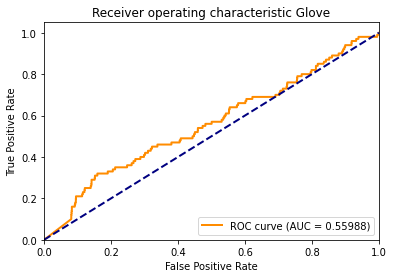

Threshold=0.0397


In [148]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Extraer características y etiquetas
X = questions_df_new_glove['PROBABILITY'].to_numpy()
y = questions_df_new_glove['SIMILARITY'].to_numpy()

y = y.astype('int')  # convertir a tipo de datos entero
y = pd.Series(y).fillna(0).values  # reemplazar valores nulos con ceros

# Dividir en conjuntos de entrenamiento y prueba
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# Entrenar modelo de regresión logística
model = LogisticRegression(solver='lbfgs')
model.fit(trainX.reshape(-1, 1), trainy)

# Predecir probabilidades en el conjunto de prueba
yhat = model.predict_proba(testX.reshape(-1, 1))
# Mantener las probabilidades positivas
probs = yhat[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(testy, probs)
roc_auc = auc(fpr, tpr)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)

# Graficar curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Glove')
plt.legend(loc="lower right")
plt.show()

# Encontrar el mejor umbral
ix = argmax(tpr - fpr)
threshold = thresholds[ix]

# Imprimir el mejor umbral
print('Threshold=%.4f' % (thresholds[ix]))


AUC=0.62800


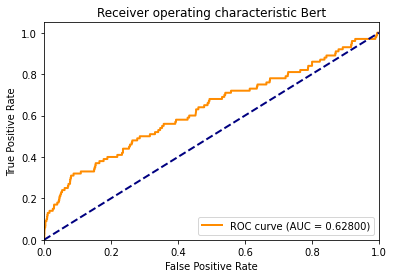

Threshold=0.0508


In [151]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Extraer características y etiquetas
X = questions_df_new_bert['PROBABILITY'].to_numpy()
y = questions_df_new_bert['SIMILARITY'].to_numpy()

y = y.astype('int')  # convertir a tipo de datos entero
y = pd.Series(y).fillna(0).values  # reemplazar valores nulos con ceros

# Dividir en conjuntos de entrenamiento y prueba
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# Entrenar modelo de regresión logística
model = LogisticRegression(solver='lbfgs')
model.fit(trainX.reshape(-1, 1), trainy)

# Predecir probabilidades en el conjunto de prueba
yhat = model.predict_proba(testX.reshape(-1, 1))
# Mantener las probabilidades positivas
probs = yhat[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(testy, probs)
roc_auc = auc(fpr, tpr)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)

# Graficar curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Bert')
plt.legend(loc="lower right")
plt.show()

# Encontrar el mejor umbral
ix = argmax(tpr - fpr)
threshold = thresholds[ix]

# Imprimir el mejor umbral
print('Threshold=%.4f' % (thresholds[ix]))

# print('Mejor umbral=%f' % (threshold))

In [152]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

def apply_threshold_new(probs, threshold):
    return (probs >= threshold).astype(int)

def get_threshold_new(df):
    # Extraer características y etiquetas
    X = df['PROBABILITY'].to_numpy()
    y = df['SIMILARITY'].to_numpy()
    y = y.astype('int')
    y = pd.Series(y).fillna(0).values
    
    # Dividir en conjuntos de entrenamiento y prueba
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

    # Entrenar modelo de regresión logística
    model = LogisticRegression(solver='lbfgs')
    model.fit(trainX.reshape(-1, 1), trainy)

    # Predecir probabilidades en todo el conjunto de datos
    yhat = model.predict_proba(X.reshape(-1, 1))
    probs = yhat[:, 1]

    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)

    # Encontrar el mejor umbral
    ix = np.argmax(tpr - fpr)
    threshold = thresholds[ix]

    # # Aplicar el umbral a las probabilidades predichas
    preds = apply_threshold(probs, threshold)

    return threshold, preds


AUC=0.62800
Threshold=0.0449
Precision=0.086
Accuracy=0.834
Recall=0.392
F1 score=0.141


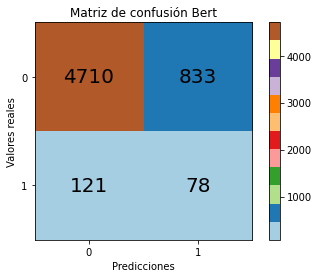

                                         ES_ID_QUESTION  \
0     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
1     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
2     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
3     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
4     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
...                                                 ...   
5737  Validacion previa usando el formulario de Crea...   
5738  Validacion previa usando el formulario de Crea...   
5739  Validacion previa usando el formulario de Crea...   
5740  Validacion previa usando el formulario de Crea...   
5741  Validacion previa usando el formulario de Crea...   

                                         EN_ID_QUESTION   ES_ID     EN_ID  \
0             Class Based Views VS Function Based Views     224  14788181   
1                               In a new Django project     224  17788801   
2     Referencing the current user in Class Based Vi...     

In [153]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Obtener el umbral y las etiquetas predichas
threshold , preds = get_threshold_new(questions_df_new_bert)

# Calcular matriz de confusión
cm = confusion_matrix(questions_df_new_bert['SIMILARITY'], preds)

precision = precision_score(questions_df_new_bert['SIMILARITY'], preds)
accuracy = accuracy_score(questions_df_new_bert['SIMILARITY'], preds)
recall = recall_score(questions_df_new_bert['SIMILARITY'], preds)
f1 = f1_score(questions_df_new_bert['SIMILARITY'], preds)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)
print('Threshold=%.4f' % threshold)
print('Precision=%.3f' % precision)
print('Accuracy=%.3f' % accuracy)
print('Recall=%.3f' % recall)
print('F1 score=%.3f' % f1)

# Graficar matriz de confusión
plt.imshow(cm, cmap='Paired')
plt.title('Matriz de confusión Bert')
plt.colorbar()
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black', fontsize=20)
plt.show()

questions_df_new_bert['PROBABILITY'] = preds
print(questions_df_new_bert)


AUC=0.62800
Threshold=0.0744
Precision=0.072
Accuracy=0.827
Recall=0.337
F1 score=0.119


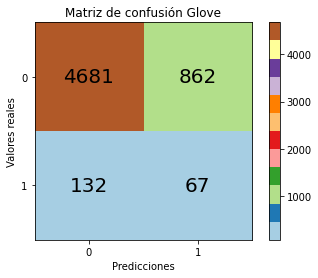

                                         ES_ID_QUESTION  \
0     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
1     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
2     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
3     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
4     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
...                                                 ...   
5737  Validacion previa usando el formulario de Crea...   
5738  Validacion previa usando el formulario de Crea...   
5739  Validacion previa usando el formulario de Crea...   
5740  Validacion previa usando el formulario de Crea...   
5741  Validacion previa usando el formulario de Crea...   

                                         EN_ID_QUESTION   ES_ID     EN_ID  \
0             Class Based Views VS Function Based Views     224  14788181   
1                               In a new Django project     224  17788801   
2     Referencing the current user in Class Based Vi...     

In [144]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Obtener el umbral y las etiquetas predichas
threshold , preds = get_threshold_new(questions_df_new_glove)

# Calcular matriz de confusión
cm = confusion_matrix(questions_df_new_glove['SIMILARITY'], preds)
# print(cm)

precision = precision_score(questions_df_new_glove['SIMILARITY'], preds)
accuracy = accuracy_score(questions_df_new_glove['SIMILARITY'], preds)
recall = recall_score(questions_df_new_glove['SIMILARITY'], preds)
f1 = f1_score(questions_df_new_glove['SIMILARITY'], preds)

# Imprimir los resultados
print('AUC=%.5f' % roc_auc)
print('Threshold=%.4f' % threshold)
print('Precision=%.3f' % precision)
print('Accuracy=%.3f' % accuracy)
print('Recall=%.3f' % recall)
print('F1 score=%.3f' % f1)

# Graficar matriz de confusión
plt.imshow(cm, cmap='Paired')
plt.title('Matriz de confusión Glove')
plt.colorbar()
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black', fontsize=20)
plt.show()

questions_df_new_glove['PROBABILITY'] = preds
print(questions_df_new_glove)


In [132]:
from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
import csv
import os
import pandas as pd

auth.authenticate_user()
drive.mount("/content/drive")

# Nombre del nuevo archivo de texto plano TSV
output_file_name_bert = 'outputBertMatrix.txt'
output_file_name_glove = 'outputGloveMatrix.txt'

#bert 
# Crea un archivo de texto plano TSV en Google Drive
drive_service_bert = build('drive', 'v3')
file_metadata_bert = {'name': output_file_name_bert, 'mimeType': 'text/plain'}
output_file_bert = drive_service_bert.files().create(body=file_metadata_bert, fields='id').execute()

# Obtiene el ID del archivo de texto plano TSV creado
output_file_id_bert = output_file_bert.get('id')
output_file_url_bert = f'https://drive.google.com/open?id={output_file_id_bert}'

with open(output_file_name_bert, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerow(['ES_ID_QUESTION','EN_ID_QUESTION', 'ES_ID','EN_ID','SIMILARITY','PROBABILITY'])


#glove
# Crea un archivo de texto plano TSV en Google Drive
drive_service_glove = build('drive', 'v3')
file_metadata_glove = {'name': output_file_name_glove, 'mimeType': 'text/plain'}
output_file_glove = drive_service_glove.files().create(body=file_metadata_glove, fields='id').execute()

# Obtiene el ID del archivo de texto plano TSV creado
output_file_id_glove = output_file_glove.get('id')
output_file_url_glove = f'https://drive.google.com/open?id={output_file_id_glove}'

with open(output_file_name_glove, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerow(['ES_ID_QUESTION','EN_ID_QUESTION', 'ES_ID','EN_ID','SIMILARITY','PROBABILITY'])

auth.authenticate_user()
drive.mount("/content/drive")

import pandas as pd
print(questions_df_new_glove)

with open(output_file_name_glove, 'a', newline='') as tsvfile:
            writer = csv.writer(tsvfile, delimiter='\t')
            writer.writerows(questions_df_new_glove.values.tolist())
drive_service_glove.files().update(fileId=output_file_id_glove, media_body=output_file_name_glove).execute()  # Guarda el archivo en Google Drive
print(f"Guardadas glove {i+1} filas, archivo guardado en {output_file_url_glove}")

#bert
with open(output_file_name_bert, 'a', newline='') as tsvfile:
            writer = csv.writer(tsvfile, delimiter='\t')
            writer.writerows(questions_df_new_bert.values.tolist())
drive_service_bert.files().update(fileId=output_file_id_bert, media_body=output_file_name_bert).execute()  # Guarda el archivo en Google Drive
print(f"Guardadas bert {i+1} filas, archivo guardado en {output_file_url_bert}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                         ES_ID_QUESTION  \
0     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
1     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
2     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
3     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
4     Vistas Basadas en Funciones (FBV) VS. Vistas B...   
...                                                 ...   
5737  Validacion previa usando el formulario de Crea...   
5738  Validacion previa usando el formulario de Crea...   
5739  Validacion previa usando el formulario de Crea...   
5740  Validacion previa usando el formulario de Crea...   
5741  Validacion previa usando el formulario de Crea...   

                                         EN_ID_QUESTION   ES_ID     EN_ID  \
0             Class Based Views VS Function Based Views     224  14788181   
1       

Guardadas glove 2 filas, archivo guardado en https://drive.google.com/open?id=1tgms3j_nYvkpYfcKIQIQZ8zNo_2KeT0s
Guardadas bert 2 filas, archivo guardado en https://drive.google.com/open?id=1b6bWuvyOaXa6BLeHJ5zUQ5sEYasrjraW
